# Documentation
**Author:** Spencer Ressel

**Created:** 2023.01.17

***

This script is a compilation of functions that serve to recreate the figures of 
two papers, Wheeler and Hendon (2004) and Jiang et al. (2020).
The Wheeler and Hendon (2004) paper describes the creation of a real-time multivariate
MJO index (RMM), and splits the MJO into 8 phases based on the RMM index. 
The Jiang et al. (2020) paper is a broad overview of the MJO,
where the specific figure (Fig. 1) recreated is a composite of MJO-associated rainfall
anomalies during boreal winter for each MJO phase.

***

**Inputs:**     
* Global 2.5° x 2.5° resolution, daily timeseries in netCDF format:
    - precipitation from TRMM
    - outgoing longwave radiation (OLR) data from *Liebmann and Smith (1996)*
    - 200 hPa zonal and meridional wind from ERA5 reanalysis
    - 850 hPa zonal and meridional wind from ERA5 reanalysis
                
**Dependencies:**
* mjo_mean_state_diagnostics.py

# Imports

In [1]:
import os

# Data processing tools
import numpy as np
import scipy
import scipy.signal as signal
from scipy.optimize import curve_fit
import xarray as xr
import mjo_mean_state_diagnostics as mjo

# Plotting
from matplotlib import pyplot as plt
from matplotlib import ticker as mticker
from matplotlib import colors as mcolors
from matplotlib.gridspec import GridSpec
from matplotlib.animation import FuncAnimation

# Cartopy
from cartopy import crs as ccrs
from cartopy import feature as cf
from cartopy import util as cutil
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter, LongitudeLocator, LatitudeLocator

# Seaborn
import seaborn as sns

# Set Physical Constants and Analysis Parameters

In [2]:
# Set time bounds
# TIME_MIN = '1979-01-01T00:00:00.000000000'
# TIME_MAX = '2001-12-31T00:00:00.000000000'
TIME_MIN = '1999-01-01T00:00:00.000000000'
TIME_MAX = '2018-12-31T00:00:00.000000000'

SAMPLING_FREQUENCY = 1

# Set latitude bounds
LATITUDE_SOUTH = -30
LATITUDE_NORTH = 30

# Set central longitude
CENTRAL_LONGITUDE = 160

# Set longitude bounds
LONGITUDE_MIN = 0
LONGITUDE_MAX = 360

# Cut-off periods for intraseasonal filtering
INTRASEASONAL_LOWCUT = 100
INTRASEASONAL_HIGHCUT = 20

# Seconds per day
SECONDS_PER_DAY = 24 * 3600

# Load Data

In [3]:
# TRMM Precipitation
data_directory_precip = r"/home/disk/eos7/sressel/Research/Data/NASA/TRMM/"
file_name_precip = "trmm_precipitation_daily_1998_2018.nc"
data_precipitation = xr.open_dataset(
    data_directory_precip + file_name_precip, engine="netcdf4"
)
precipitation = data_precipitation['prec'].sortby('lat')

# NASA OLR (Liebmann and Smith 1996)
data_directory_olr = r"/home/disk/eos7/sressel/Research/Data/NOAA/"
file_name_olr = "olr.day.mean.nc"
data_olr = xr.open_dataset(data_directory_olr + file_name_olr, engine="netcdf4")
outgoing_longwave_radiation = data_olr['olr'].sortby('lat')

# #### Load zonal wind data
data_directory_zonal_wind = r"/home/disk/eos7/sressel/Research/Data/ECMWF/ERA5/"
file_name_zonal_wind = "daily_2_5_degree_zonal_wind_pressure_levels_1979_2020.nc"
data_zonal_wind = xr.open_dataset(
    data_directory_zonal_wind + file_name_zonal_wind, engine="netcdf4"
).rename({'level':'lev', 'latitude':'lat', 'longitude':'lon'})


zonal_wind = data_zonal_wind["u"].sortby('lat')
zonal_wind_longitudes = zonal_wind["lon"].values
zonal_wind_longitudes[zonal_wind_longitudes < 0] += 360
zonal_wind["lon"] = zonal_wind_longitudes
zonal_wind = zonal_wind.sortby(zonal_wind.lon)

upper_level_zonal_wind = zonal_wind.sel(lev=200)
lower_level_zonal_wind = zonal_wind.sel(lev=850)

#### Load meridional wind data
data_directory_meridional_wind = r"/home/disk/eos7/sressel/Research/Data/ECMWF/ERA5/"
file_name_meridional_wind = (
    "daily_2_5_degree_meridional_wind_pressure_levels_1979_2020.nc"
)
data_meridional_wind = xr.open_dataset(
    data_directory_meridional_wind + file_name_meridional_wind, engine="netcdf4"
).rename({'level':'lev', 'latitude':'lat', 'longitude':'lon'})

meridional_wind = data_meridional_wind["v"].sortby('lat')
meridional_wind_longitudes = meridional_wind["lon"].values
meridional_wind_longitudes[meridional_wind_longitudes < 0] += 360
meridional_wind["lon"] = meridional_wind_longitudes
meridional_wind = meridional_wind.sortby(meridional_wind.lon)

upper_level_meridional_wind = meridional_wind.sel(lev=200)
lower_level_meridional_wind = meridional_wind.sel(lev=850)

time = outgoing_longwave_radiation.time
latitude = outgoing_longwave_radiation.lat
longitude = outgoing_longwave_radiation.lon

variables_dict = {
    'precipitation' : precipitation,
    'outgoing longwave radiation' : outgoing_longwave_radiation,
    'upper level zonal wind' : upper_level_zonal_wind,
    'lower level zonal wind' : lower_level_zonal_wind,
    'upper level meridional wind' : upper_level_meridional_wind,
    'lower level meridional wind' : lower_level_meridional_wind,
}

# Process Data

Detrend the data, remove the annual cycle and the first three harmonics (seasonal cycle), and filter the data on intraseasonal timescales

## Subset Data
Specifically select the data from times of interest and from tropical latitudes

In [4]:
variables_subset = {}

for variable in variables_dict:
    if variable != 'precipitation':
        variables_subset[variable] = variables_dict[variable].copy(deep=True)
        variables_subset[variable] = variables_dict[variable].sel(
            time=slice(TIME_MIN, TIME_MAX),
            lat=slice(LATITUDE_SOUTH, LATITUDE_NORTH)
        )

variables_subset['precipitation'] = variables_dict['precipitation'].copy(deep=True).sel(
    time=slice('1999-01-01T00:00:00.000000000', '2018-12-31T00:00:00.000000000'),
    lat=slice(LATITUDE_SOUTH, LATITUDE_NORTH)
)
        
latitude = latitude.sel(lat=slice(LATITUDE_SOUTH, LATITUDE_NORTH))
time = time.sel(time=slice(TIME_MIN, TIME_MAX))

### Plot subset data

In [5]:
# Calculate anomalies relative to a global grand mean
def calculate_anomalies(variable):
    return variable - variable.mean()

In [6]:
def modified_colormap(colormap, central_color, central_width, blend_strength):    
    '''
    This function modifies a colormap to set the central region to be white. 
    Within the region specified by the 'width' parameter, the colormap is blended towards white using a linspace.
    
    Parameters:
        colormap (str): The name of an existing matplotlib colormap
        central_width (float): The width of the region to be set to white
        blend_strength (float): The width of the regions to be blended to white

    Returns:
        modified_colormap (matplotlib.colors.LinearSegmentedColormap): The modified colormap
    
    '''
    # Import libraries
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib import colors as mcolors
    
    try:
        c = mcolors.cnames[central_color]
    except: 
        raise KeyError('Not a matplotlib named color')
        
    central_color = list(mcolors.to_rgba(central_color))
    
    # Raise an error if the width is not between 0 and 1
    if ((central_width < 0)+(central_width > 1)):
        raise ValueError('Central width must be in range [0, 1]')
    elif ((blend_strength < 0) + (blend_strength > 1)):
        raise ValueError('Blend strength must be in range [0, 1]')
    
    # Convert the widths to the range [0, 127]
    else:             
        central_width = int(127*central_width)
        blend_strength = int(blend_strength*(127-central_width))

    # Get the colormap values
    original_colormap = plt.cm.get_cmap(colormap)
    newcolors = original_colormap(np.linspace(0, 1, 256))
    
    # Get the value of the colormap 'width' values left of the center, and blend from that value to white at the center
    newcolors[128-central_width-blend_strength:128-central_width, :] = np.linspace(
        newcolors[128-central_width-blend_strength, :], 
        central_color, 
        blend_strength
    )
    
    newcolors[128-central_width:128+central_width, :] = central_color
    
    # Get the value of the colormap 'width' values right of the center, and blend from white at the center to that value
    newcolors[128+central_width:128+central_width+blend_strength, :] = np.linspace(
        central_color,
        newcolors[128+central_width+blend_strength, :], 
        blend_strength
    )
    
    # Create a new colormap object from the modified map
    modified_colormap = mcolors.LinearSegmentedColormap.from_list(colormap+'_modified', newcolors)
    
    return modified_colormap

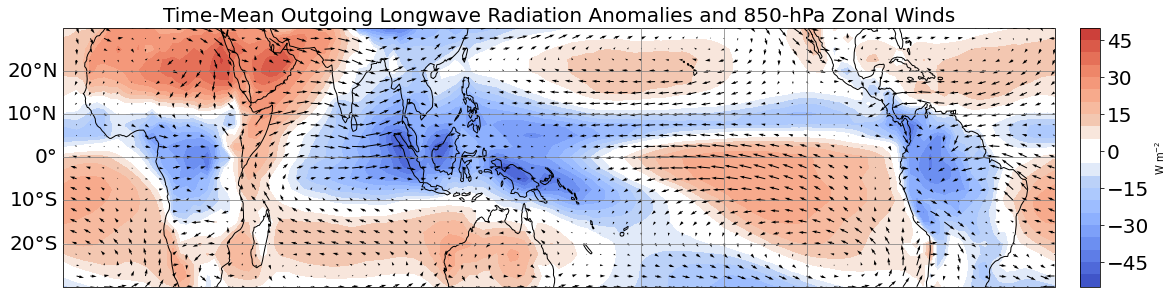

In [7]:
plt.style.use('default')
plt.rcParams.update({'font.size':24})
cmap_modified = modified_colormap('coolwarm', 'white', 0.1, 0.1)
# cmap_modified = 'BrBG'
coastline_width = 1

outgoing_longwave_radiation_anomalies = calculate_anomalies(variables_subset['outgoing longwave radiation'])
lower_level_zonal_wind_anomalies = calculate_anomalies(variables_subset['lower level zonal wind'])
lower_level_meridional_wind_anomalies = calculate_anomalies(variables_subset['lower level meridional wind'])

fig = plt.figure(figsize=(16,4))
gs = GridSpec(1, 2, width_ratios=[1, 0.02], figure=fig)
gs.update(top=.95, bottom=0.05, left=0.05, right=.95, hspace=0, wspace=0.05)

proj = ccrs.PlateCarree(central_longitude=-205)
data_crs = ccrs.PlateCarree()

ax = fig.add_subplot(gs[0], projection=proj)
cb_ax = fig.add_subplot(gs[1])


# Moisture Tendency
ax.set_title(f"Time-Mean Outgoing Longwave Radiation Anomalies and 850-hPa Zonal Winds", fontsize=20)

# Add cyclic point
cdata, clon = cutil.add_cyclic_point(
    outgoing_longwave_radiation_anomalies.mean(dim='time'),
    coord=outgoing_longwave_radiation_anomalies.lon
)

# Plot data
im = ax.contourf(
    clon, 
    outgoing_longwave_radiation_anomalies.lat, 
    cdata, 
    transform=data_crs,
    cmap=cmap_modified,
    norm=mcolors.CenteredNorm(),
    levels=21
)

# Add colorbar
cbar = fig.colorbar(im, cax=cb_ax)
cbar.ax.tick_params(labelsize=20)
cbar.set_label(r'W m$^{-2}$')

arrow_spacing = 1
ax.quiver(
    lower_level_zonal_wind_anomalies.lon[::2*arrow_spacing],
    lower_level_zonal_wind_anomalies.lat[::arrow_spacing],
    lower_level_zonal_wind_anomalies.mean(dim='time').values[::arrow_spacing, ::2*arrow_spacing],
    lower_level_meridional_wind_anomalies.mean(dim='time').values[::arrow_spacing, ::2*arrow_spacing],
    width=0.001,
    scale=500,
    transform=data_crs
)

ax.set_aspect('auto')
ax.set_xlabel('')
# ax.set_global()
ax.add_feature(cf.COASTLINE, lw=coastline_width)

gl = ax.gridlines(
    crs=proj,
    draw_labels=True,
    linewidth=1,
    color="gray",
    alpha=0.75,
    linestyle="-",
    zorder=15

)

gl.right_labels = False
gl.top_labels = False
# gl.xlocator = mticker.FixedLocator(np.arange(0,360,30))
gl.xlocator = mticker.FixedLocator([30,60,90])
# gl.xlocator = LongitudeLocator(30)
gl.xformatter = LongitudeFormatter()
gl.xlabel_style = {'fontsize':20}
gl.ylocator = mticker.FixedLocator(np.arange(-40,40,10))
gl.yformatter = LatitudeFormatter()
gl.ylabel_style = {'fontsize':20}

plt.show()

## Remove mean & Detrend the data

In [8]:
variables_detrended = {}

for variable in variables_dict:
    variables_detrended[variable] = variables_subset[variable].copy(deep=True)
    variables_detrended[variable].values = variables_detrended[variable] - variables_detrended[variable].mean(dim='time')
    variables_detrended[variable].values = signal.detrend(
                                               variables_subset[variable], 
                                               axis=0, 
                                               type='linear'
                                           )

## Remove the Annual Cycle

In [9]:
variables_deannualized = {}
variables_annual_cycle = {}

for variable in variables_dict:
    variables_deannualized[variable] = variables_subset[variable].copy(deep=True)
    variables_annual_cycle[variable] = variables_subset[variable].copy(deep=True)
    
    [           
        variables_deannualized[variable].values,
        variables_annual_cycle[variable].values,
    ] = mjo.remove_annual_cycle_matrix(
        variables_subset[variable], 
        time = variables_subset[variable].time.values,
        lat =  variables_subset[variable].lat.values,
        lon =  variables_subset[variable].lon.values
    )    

# Identify the MJO's spectral peak

There should be a coherency between zonal wind and outgoing longwave radiation, with a phase relationship of 90°. Minima in OLR correspond to maxima in convection and thus near-zero zonal winds

## Choose a single location

In [10]:
# Specify location to find MJO signal
single_location_latitude = 0
single_location_longitude = 120

variables_single_location = {}
for variable in variables_dict:
    variables_single_location[variable] = variables_deannualized[variable].copy(deep=True)
    variables_single_location[variable] = variables_deannualized[variable].sel(
        lat=single_location_latitude,
        lon=single_location_longitude
    )

## Standardized time series

In [11]:
def standardize_time_series(time_series):
    return (time_series - np.mean(time_series))/np.std(time_series)

In [12]:
# Remove the mean and divide by the standard deviation
outgoing_longwave_radiation_standardized = standardize_time_series(
    variables_single_location['outgoing longwave radiation']
)
lower_level_zonal_wind_standardized = standardize_time_series(
    variables_single_location['lower level zonal wind']
)
upper_level_zonal_wind_standardized = standardize_time_series(
    variables_single_location['upper level zonal wind']
)

print('Check standardization')
print(f"Time Series Means:\nOLR: {outgoing_longwave_radiation_standardized.mean(dim='time').values:>10.2f} \n"
      + f"U850:  {lower_level_zonal_wind_standardized.mean(dim='time').values:>8.2f}\n"
      + f"U200:  {upper_level_zonal_wind_standardized.mean(dim='time').values:>8.2f}")
print(f"Time Series Standard Deviations:\nOLR: {outgoing_longwave_radiation_standardized.std(dim='time').values:>10.2f} \n"
      + f"U850:  {lower_level_zonal_wind_standardized.std(dim='time').values:>8.2f}\n"
      + f"U200:  {upper_level_zonal_wind_standardized.std(dim='time').values:>8.2f}")

Check standardization
Time Series Means:
OLR:       0.00 
U850:     -0.00
U200:     -0.00
Time Series Standard Deviations:
OLR:       1.00 
U850:      1.00
U200:      1.00


## Calculate autocorrelation

In [13]:
# Calculate the autocorrelation for a given lag
def calculate_autocorrelation(time_series, lag):
    standard_deviation = np.std(time_series)
    mean = np.mean(time_series)
    time_series = (time_series - mean)/standard_deviation
    
    autocorrelation = np.sum(
        (time_series[lag:]) 
      * (time_series[:-lag]),
        axis=0
    ) / ((len(time_series) - lag))
    
    return autocorrelation

In [14]:
outgoing_longwave_radiation_autocorrelation = calculate_autocorrelation(
    outgoing_longwave_radiation_standardized, 
    1
)
lower_level_zonal_wind_autocorrelation = calculate_autocorrelation(
    lower_level_zonal_wind_standardized,
    1
)

upper_level_zonal_wind_autocorrelation = calculate_autocorrelation(
    upper_level_zonal_wind_standardized,
    1
)

print("Autocorrelations")
print(f"OLR:  {outgoing_longwave_radiation_autocorrelation.values:0.2f}")
print(f"U850: {lower_level_zonal_wind_autocorrelation.values:0.2f}")
print(f"U200: {upper_level_zonal_wind_autocorrelation.values:0.2f}")

Autocorrelations
OLR:  1.00
U850: 1.00
U200: 1.00


## Compute power spectra

In [15]:
# Specify window size
window_size = 256

# Calculate raw spectra

frequency_olr, outgoing_longwave_radiation_power_spectra = signal.welch(
    outgoing_longwave_radiation_standardized,
    nperseg=window_size,
    noverlap=window_size//2, 
    detrend='linear',
    fs=1
)

frequency_lower, lower_level_zonal_wind_power_spectra = signal.welch(
    lower_level_zonal_wind_standardized,
    nperseg=window_size,
    noverlap=window_size//2, 
    detrend='linear',
    fs=1
)

frequency_upper, upper_level_zonal_wind_power_spectra = signal.welch(
    upper_level_zonal_wind_standardized,
    nperseg=window_size,
    noverlap=window_size//2, 
    detrend='linear',
    fs=1
)

outgoing_longwave_radiation_power_normalized = outgoing_longwave_radiation_power_spectra/np.mean(outgoing_longwave_radiation_power_spectra)
lower_level_zonal_wind_power_normalized = lower_level_zonal_wind_power_spectra/np.mean(lower_level_zonal_wind_power_spectra)
upper_level_zonal_wind_power_normalized = upper_level_zonal_wind_power_spectra/np.mean(upper_level_zonal_wind_power_spectra)

## Fit red spectrum

In [16]:
def calculate_red_spectrum(frequency, autocorrelation):
    red_spectrum = (1-autocorrelation**2)/(1-(2*autocorrelation*np.cos(frequency*2*np.pi))+autocorrelation**2)
    return red_spectrum

In [17]:
p_critical = 0.95

# Fit red noise spectrum to data
[olr_parameters, olr_covariance] = curve_fit(
    calculate_red_spectrum, 
    frequency_olr, 
    outgoing_longwave_radiation_power_normalized,
    p0=(0.5)
)

outgoing_longwave_radiation_red_spectrum = calculate_red_spectrum(frequency_olr, olr_parameters[0])

[lower_parameters, lower_covariance] = curve_fit(
    calculate_red_spectrum, 
    frequency_lower, 
    lower_level_zonal_wind_power_normalized,
    p0=(0.5)
)
lower_level_zonal_wind_red_spectrum = calculate_red_spectrum(frequency_lower, lower_parameters[0])

[upper_parameters, upper_covariance] = curve_fit(
    calculate_red_spectrum, 
    frequency_lower, 
    upper_level_zonal_wind_power_normalized,
    p0=(0.5)
)
upper_level_zonal_wind_red_spectrum = calculate_red_spectrum(frequency_upper, upper_parameters[0])

# Estimate degrees of freedom
degrees_of_freedom_numerator = 2*len(outgoing_longwave_radiation_standardized)/window_size
degrees_of_freedom_denominator = len(outgoing_longwave_radiation_standardized)//2
f_critical = scipy.stats.f.ppf(p_critical, degrees_of_freedom_numerator, degrees_of_freedom_denominator)

## Plot Power Spectra

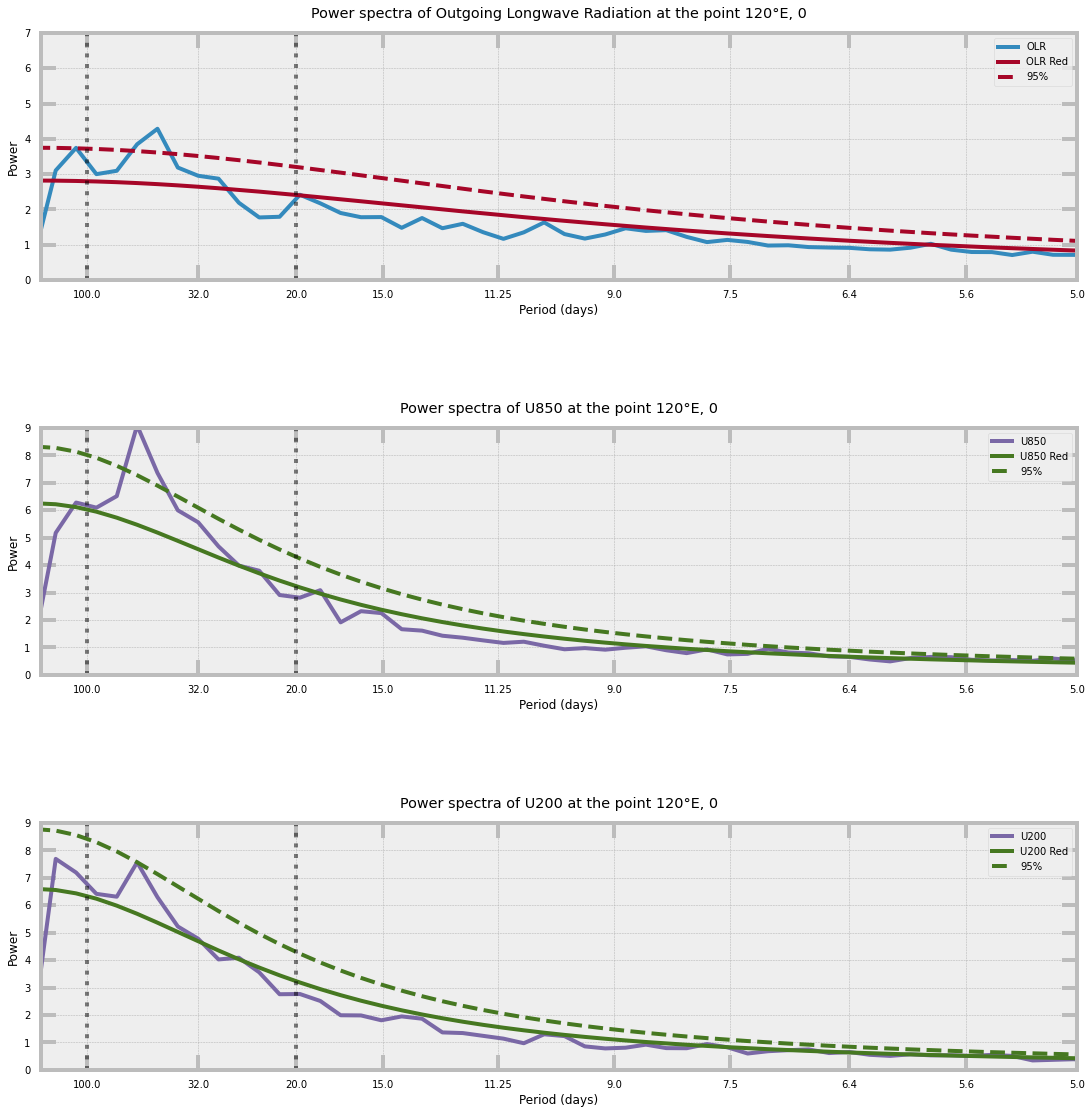

In [18]:
# Specify periods to plot as xticks
periods = np.array([100, 32, 20,  15, 11.25, 9, 7.5, 6.4, 5.6, 5])
frequency_from_period = 1/periods

plt.style.use('bmh')

gs = GridSpec(3, 1, height_ratios=(1, 1, 1))
gs.update(top=.95, bottom=0.05, left=0.05, right=.95, hspace=0.6, wspace=0.05)
f = plt.figure(figsize=(16,16))

ax = []
ax.append(f.add_subplot(gs[0]))
ax.append(f.add_subplot(gs[1]))
ax.append(f.add_subplot(gs[2]))

ax[0].set_title(f'Power spectra of Outgoing Longwave Radiation' +
                f' at the point {single_location_longitude:0.0f}°E, {single_location_latitude:0.0f}', 
                pad=15)

# Plot OLR Power Spectrum
ax[0].plot(
    frequency_olr, 
    outgoing_longwave_radiation_power_normalized, 
    lw=4, 
    color='#348ABD', 
    label='OLR'
)

# OLR Red Spectrum Fit
ax[0].plot(
    frequency_olr, 
    outgoing_longwave_radiation_red_spectrum, 
    lw=4, 
    color='#A60628', 
    ls='-',
    label='OLR Red'
)

# OLR 95% confidence level
ax[0].plot(
    frequency_olr, 
    f_critical*outgoing_longwave_radiation_red_spectrum, 
    lw=4, 
    color='#A60628', 
    ls='--', 
    label='95%'
)
ax[0].set_ylim(0,7)


# Plot power spectrum of lower level zonal winds
ax[1].set_title(f'Power spectra of U850' +
                f' at the point {single_location_longitude:0.0f}°E, {single_location_latitude:0.0f}', 
                pad=15)

# Power spectrum
ax[1].plot(
    frequency_lower, 
    lower_level_zonal_wind_power_normalized, 
    lw=4, 
    color='#7A68A6', 
    label='U850'
)

# Red Spectrum Fit
ax[1].plot(
    frequency_lower, 
    lower_level_zonal_wind_red_spectrum, 
    lw=4, 
    color='#467821', 
    ls='-', 
    label='U850 Red'
)

# 95% confidence level
ax[1].plot(
    frequency_lower, 
    f_critical*lower_level_zonal_wind_red_spectrum, 
    lw=4, 
    color='#467821', 
    ls='--', 
    label='95%'
)
ax[1].set_ylim(0,9)


# Plot power spectrum of upper level zonal winds
ax[2].set_title(f'Power spectra of U200' +
                f' at the point {single_location_longitude:0.0f}°E, {single_location_latitude:0.0f}', 
                pad=15)

# Power spectrum
ax[2].plot(
    frequency_upper, 
    upper_level_zonal_wind_power_normalized, 
    lw=4, 
    color='#7A68A6', 
    label='U200'
)

# Red Spectrum Fit
ax[2].plot(
    frequency_upper, 
    upper_level_zonal_wind_red_spectrum, 
    lw=4, 
    color='#467821', 
    ls='-', 
    label='U200 Red'
)

# 95% confidence level
ax[2].plot(
    frequency_upper, 
    f_critical*upper_level_zonal_wind_red_spectrum, 
    lw=4, 
    color='#467821', 
    ls='--', 
    label='95%'
)
ax[2].set_ylim(0,9)

for axis in range(3):
    # Add vertical lines to show the intraseasonal band
    ax[axis].axvline(x = 1/INTRASEASONAL_LOWCUT, ls=':', lw=4, color='black', alpha=0.5)
    ax[axis].axvline(x = 1/INTRASEASONAL_HIGHCUT, ls=':', lw=4, color='black', alpha=0.5)

    # Add legend
    ax[axis].legend()

    # Configure axes
    ax[axis].set_ylabel('Power')
    ax[axis].set_xlabel('Period (days)')

    for edge in ['top','bottom','left','right']:
        ax[axis].spines[edge].set_linewidth(4)
    ax[axis].tick_params(
        which='major',
        axis='both',
        direction='in',
        top=True,
        right=True,
        width=4,
        length=15,
        color='#bcbcbc',
        pad=10
    )    

    ax[axis].set_xticks(ticks = frequency_from_period)
    ax[axis].xaxis.set_major_formatter(mticker.FixedFormatter(periods))
    ax[axis].set_xlim(1/1000, 1/5)
    ax[axis].set_aspect('auto')


plt.show()

## Compute coherency

In [19]:
def cohstat(dof,siglev):
    #Siglev, significance level desired, should be .95 or .99. Siglev greater
    #than .95 will default to .99, lower inputs of siglev default to .95

    # this is a rough fit to the F statistic (0.01), assuming the denominator has 100 dof.
    #f=[3.94,3.09,3.98,3.51,3.21,2.99,2.82,2.69,2.59,2.5,2.07,1.89,1.80,1.74,1.65,1.60];
    #n=[1,2,3,4,5,6,7,8,9,10,20,30,40,50,75,100];
    # this is a rough fit to the Coherency statistic (0.01), given dof as input.
    f99 = [0.99,0.684,0.602,0.536,0.482,0.438,0.401,0.342,0.264,0.215,0.175,0.147,0.112,0.075,0.057,0.045,0.023,0.002];
    f90 = [0.901,0.437,0.370,0.319,0.280,0.250,0.226,0.189,0.142,0.112,0.091,0.076,0.057,0.038,0.029,0.023,0.011,0.001];
    f95 = [0.951,0.527,0.450,0.393,0.348,0.312,0.283,0.238,0.181,0.146,0.118,0.098,0.074,0.050,0.037,0.030,0.015,0.001];
    n=[2,5,6,7,8,9,10,12,16,20,25,30,40,60,80,100,200,1000000];

    if  siglev > 0.95:
        f = f99;
    else:
        f = f95
    coh_crit = np.interp(dof,n,f)
    return coh_crit

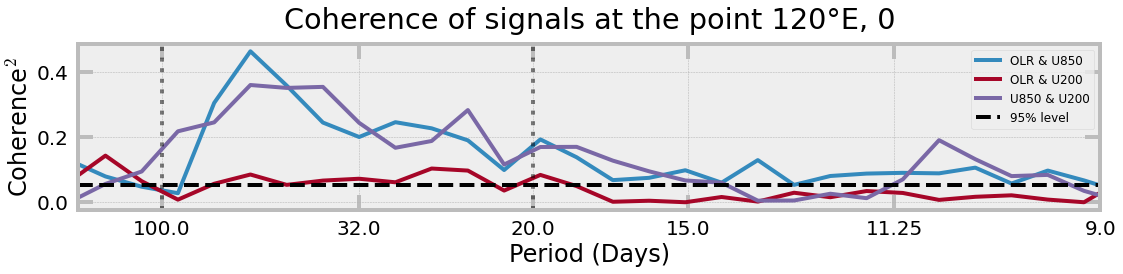

In [20]:
frequency_OLR_u850, coherence_OLR_u850 = signal.coherence(
    outgoing_longwave_radiation_standardized, 
    lower_level_zonal_wind_standardized, 
    nperseg=window_size,
    detrend='linear',
    fs=1
)

frequency_OLR_u200, coherence_OLR_u200 = signal.coherence(
    outgoing_longwave_radiation_standardized, 
    upper_level_zonal_wind_standardized, 
    nperseg=window_size,
    detrend='linear',
    fs=1
)

frequency_u850_u200, coherence_u850_u200 = signal.coherence(
    lower_level_zonal_wind_standardized, 
    upper_level_zonal_wind_standardized, 
    nperseg=window_size,
    detrend='linear',
    fs=1
)

critical_coherence = cohstat(degrees_of_freedom_numerator, p_critical)

plt.style.use('bmh')
plt.rcParams.update({'font.size':20})
[fig, ax] = plt.subplots(figsize=(16,9))
ax.set_title(f'Coherence of signals' +
                f' at the point {single_location_longitude:0.0f}°E, {single_location_latitude:0.0f}', 
                pad=15)

# Plot coherence of OLR & U850
ax.plot(
    frequency_OLR_u850,
    coherence_OLR_u850,
    lw=4,
    label='OLR & U850'
)

# Plot coherence of OLR & U200
ax.plot(
    frequency_OLR_u200,
    coherence_OLR_u200,
    lw=4,
    label='OLR & U200'
)


# Plot coherence of U850 & U200
ax.plot(
    frequency_u850_u200,
    coherence_u850_u200,
    lw=4,
    label='U850 & U200'
)

# Plot critical coherence value
ax.axhline(critical_coherence, color='black', lw=4, ls='--', label=f'{100*p_critical:0.0f}% level')

# Plot low and high frequency cutoffs
ax.axvline(x = 1/INTRASEASONAL_LOWCUT, ls=':', lw=4, color='black', alpha=0.5)
ax.axvline(x = 1/INTRASEASONAL_HIGHCUT, ls=':', lw=4, color='black', alpha=0.5)
ax.set_xlabel('Period (Days)')
ax.set_ylabel(r'Coherence$^{2}$')
ax.set_xlim(0, 0.2)
ax.legend(fontsize=12)

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(4)
ax.tick_params(
    which='major',
    axis='both',
    direction='in',
    top=True,
    right=True,
    width=4,
    length=15,
    color='#bcbcbc',
    pad=10
)    
# ax.xaxis.set_major_locator(mticker.MaxNLocator(prune='lower'))
ax.set_xticks(ticks = frequency_from_period)
ax.xaxis.set_major_formatter(mticker.FixedFormatter(periods))
ax.set_xlim(1/1000, 1/9)
ax.set_aspect(9/256)

plt.tight_layout()
plt.show()

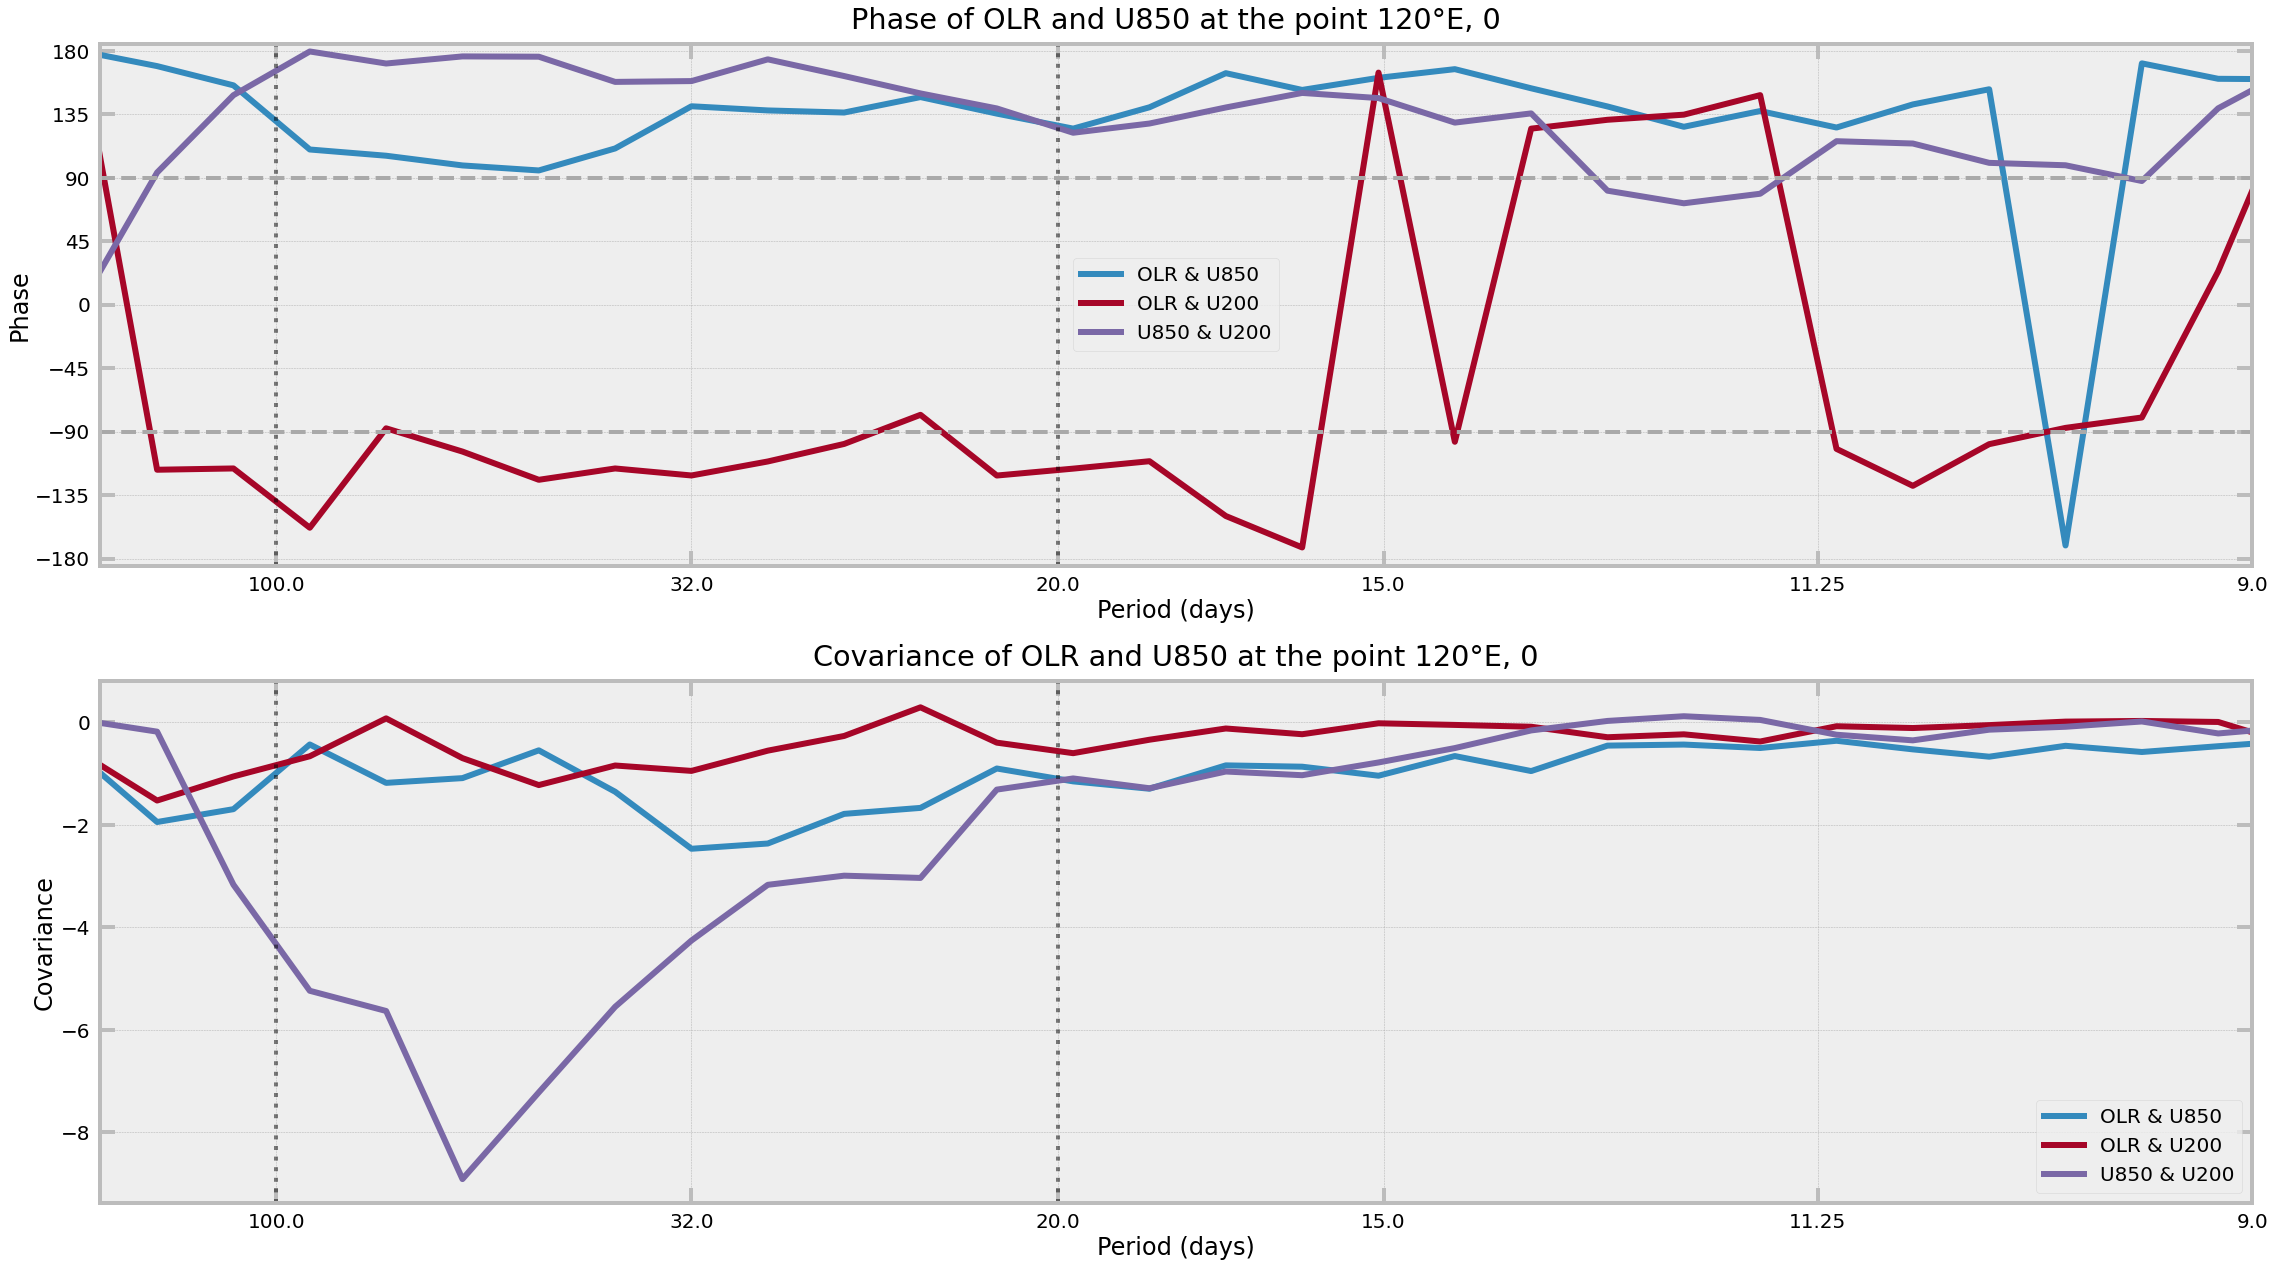

In [21]:
# Calculate cross spectrum of OLR and U850
frequency_cross_spectrum_OLR_u850, cross_spectrum_OLR_u850 = signal.csd(
    outgoing_longwave_radiation_standardized,
    lower_level_zonal_wind_standardized,
    nperseg=window_size,
    detrend='linear',
    fs=1
)

# Calculate phase and covariance
phase_OLR_u850 = np.arctan2(np.imag(cross_spectrum_OLR_u850),np.real(cross_spectrum_OLR_u850))*180/np.pi
covariance_OLR_u850 = np.real(cross_spectrum_OLR_u850)


# Calculate cross spectrum of OLR and U200
frequency_cross_spectrum_OLR_u200, cross_spectrum_OLR_u200 = signal.csd(
    outgoing_longwave_radiation_standardized,
    upper_level_zonal_wind_standardized,
    nperseg=window_size,
    detrend='linear',
    fs=1
)

# Calculate phase and covariance
phase_OLR_u200 = np.arctan2(np.imag(cross_spectrum_OLR_u200),np.real(cross_spectrum_OLR_u200))*180/np.pi
covariance_OLR_u200 = np.real(cross_spectrum_OLR_u200)


# Calculate cross spectrum of U850 and U200
frequency_cross_spectrum_u850_u200, cross_spectrum_u850_u200 = signal.csd(
    lower_level_zonal_wind_standardized,
    upper_level_zonal_wind_standardized,
    nperseg=window_size,
    detrend='linear',
    fs=1
)

# Calculate phase and covariance
phase_u850_u200 = np.arctan2(np.imag(cross_spectrum_u850_u200),np.real(cross_spectrum_u850_u200))*180/np.pi
covariance_u850_u200 = np.real(cross_spectrum_u850_u200)

plt.style.use('bmh')
[fig, ax] = plt.subplots(
    2, 
    1, 
    figsize=(32,18))

# Phase
ax[0].set_title(f'Phase of OLR and U850' +
                f' at the point {single_location_longitude:0.0f}°E, {single_location_latitude:0.0f}', 
                pad=15)

ax[0].plot(
    frequency_cross_spectrum_OLR_u850, 
    phase_OLR_u850, 
    lw=6,
    label='OLR & U850'
)

ax[0].plot(
    frequency_cross_spectrum_OLR_u200, 
    phase_OLR_u200, 
    lw=6,
    label='OLR & U200'
)

ax[0].plot(
    frequency_cross_spectrum_u850_u200, 
    phase_u850_u200, 
    lw=6,
    label='U850 & U200'
)


# Add lines at +/- 90°
ax[0].axhline(y=-90, color='darkgray', ls='--', lw=4)
ax[0].axhline(y=90, color='darkgray', ls='--', lw=4)

# Set phase-specific axis values
ax[0].set_ylim(-185, 185)
ax[0].set_yticks([-180, -135, -90, -45, 0, 45, 90, 135, 180])
ax[0].set_ylabel('Phase')
ax[0].legend()

# Covariance
ax[1].set_title(f'Covariance of OLR and U850' +
                f' at the point {single_location_longitude:0.0f}°E, {single_location_latitude:0.0f}', 
                pad=15)

ax[1].plot(
    frequency_cross_spectrum_OLR_u850, 
    covariance_OLR_u850, 
    lw=6,
    label='OLR & U850'
)

ax[1].plot(
    frequency_cross_spectrum_OLR_u200, 
    covariance_OLR_u200, 
    lw=6,
    label='OLR & U200'
)

ax[1].plot(
    frequency_cross_spectrum_u850_u200, 
    covariance_u850_u200, 
    lw=6,
    label='U850 & U200'
)
        
# Set covariance specific axis values
ax[1].set_ylabel('Covariance')    
ax[1].legend()
      
# Configure general axes
for axis in range(2):
    ax[axis].axvline(x = 1/INTRASEASONAL_LOWCUT, ls=':', lw=4, color='black', alpha=0.5)
    ax[axis].axvline(x = 1/INTRASEASONAL_HIGHCUT, ls=':', lw=4, color='black', alpha=0.5)
    ax[axis].set_xlabel('Period (days)')
    
    ax[axis].set_xlim(0, 0.2)

    for edge in ['top','bottom','left','right']:
        ax[axis].spines[edge].set_linewidth(4)
    ax[axis].tick_params(
        which='major',
        axis='both',
        direction='in',
        top=True,
        right=True,
        width=4,
        length=15,
        color='#bcbcbc',
        pad=10
    )    
    ax[1].xaxis.set_major_locator(mticker.MaxNLocator(prune='lower'))
    ax[axis].set_xticks(ticks = frequency_from_period)
    ax[axis].xaxis.set_major_formatter(mticker.FixedFormatter(periods))
    ax[axis].set_xlim(1/1000, 1/9)

plt.tight_layout()
plt.show()

This analysis clearly shows statistically significant spectra peaks in both OLR and 850-hPa zonal winds in the intraseasonal band. Additionally, there is a significant peak in coherence between the two signals in that band, with a phase relationship around -90° as expected. This is a clear indication of the MJO in the signal. 

# Wheeler and Hendon (2004) Analysis

## Filter Data 

Temporally filter the data on intraseasonal (20-100 day) timescales, using a Lanczos filter

In [22]:
nyq = 0.5
filter_order = 4
low = (1/INTRASEASONAL_LOWCUT) / nyq
high = (1/INTRASEASONAL_HIGHCUT) / nyq
b, a = signal.butter(filter_order, [low, high], btype="band")

variables_filtered = {}

for variable in variables_dict:
    variables_filtered[variable] = variables_deannualized[variable].copy(deep=True)
    variables_filtered[variable].values = signal.filtfilt(
        b, a, 
        variables_deannualized[variable], 
        axis=0
    )
    
# for variable in variables_dict:
#     variables_filtered[variable] = variables_deannualized[variable].copy(deep=True)
#     variables_filtered[variable].values = mjo.lanczos_bandpass_filter(
#     variables_deannualized[variable],
#     lowcut=(1 / INTRASEASONAL_LOWCUT),
#     highcut=(1 / INTRASEASONAL_HIGHCUT),
#     fs=SAMPLING_FREQUENCY,
#     filter_axis=0,
# )

### Plot MJO-filtered data

#### Time mean maps of OLR and 850-hPa winds

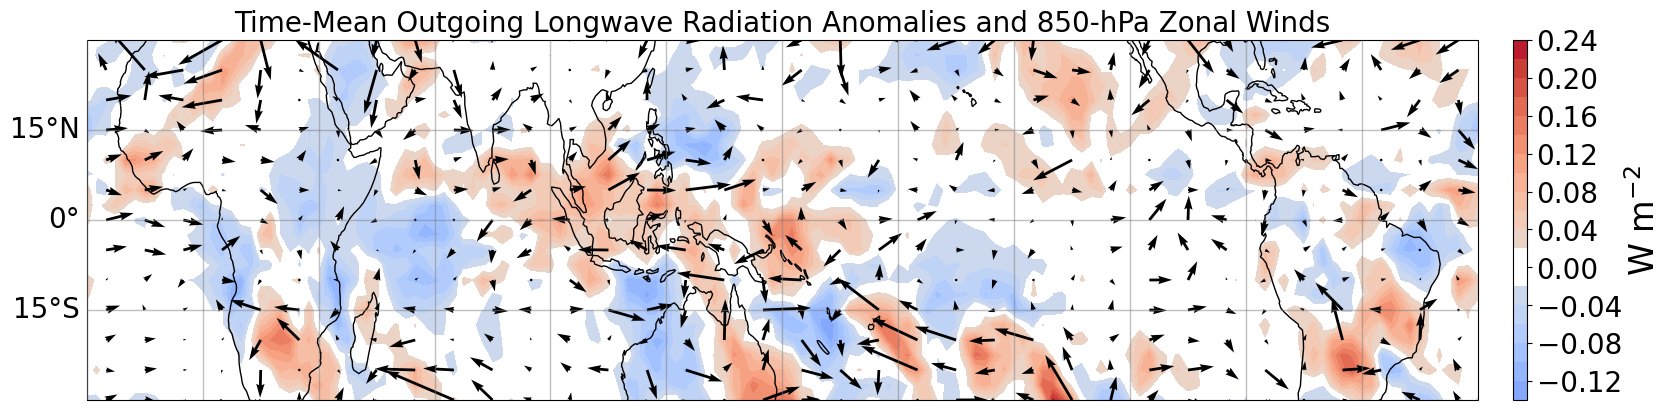

In [23]:
plt.style.use('default')
plt.rcParams.update({'font.size':24})
coastline_width = 1

olr_anomalies = (
    (variables_subset['outgoing longwave radiation']
    - variables_subset['outgoing longwave radiation'].mean(dim=['lat', 'lon'])).mean(dim='time'))


fig = plt.figure(figsize=(16,4))
gs = GridSpec(1, 2, width_ratios=[100,1], figure=fig)
gs.update(top=.95, bottom=0.05, left=0.05, right=.95, hspace=0.6, wspace=0.05)


data_crs = ccrs.PlateCarree()
proj = ccrs.PlateCarree(central_longitude=-205)

ax = fig.add_subplot(gs[0], projection=proj)
cbar_ax = fig.add_subplot(gs[1])

olr_keywords = {
    'transform':data_crs, 
    'cmap':mjo.modified_colormap('coolwarm', 'white', 0.05, 0.05),
    'norm':mcolors.CenteredNorm(),
    'levels':21
}

# Plot OLR data
ax.set_title(f"Time-Mean Outgoing Longwave Radiation Anomalies and 850-hPa Zonal Winds", fontsize=20)

# Add OLR cyclic point
cdata, clon = cutil.add_cyclic_point(
    variables_filtered['outgoing longwave radiation'].mean(dim='time'),
    coord=longitude
)

im = ax.contourf(
    clon, 
    latitude, 
    cdata, 
    **olr_keywords
)

cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.tick_params(labelsize=20)
cbar.set_label(r'W m$^{-2}$')

# Plot wind data
arrow_spacing = 2
ax.quiver(
    longitude[::2*arrow_spacing],
    latitude[::arrow_spacing],
    variables_filtered['lower level zonal wind'].mean(dim='time')[::arrow_spacing, ::2*arrow_spacing].values,
    variables_filtered['lower level meridional wind'].mean(dim='time')[::arrow_spacing, ::2*arrow_spacing].values,
    transform=data_crs,
    width=0.002,
    scale=0.5
)

# Configure axes and gridlines
ax.set_xlabel('')
ax.add_feature(cf.COASTLINE, lw=coastline_width)
ax.set_aspect('auto')

gl = ax.gridlines(
    crs=proj,
    draw_labels=True,
    linewidth=1,
    color="gray",
    alpha=0.5,
    linestyle="-",
    zorder=15

)
gl.right_labels = False
gl.top_labels = False
gl.xlocator = mticker.FixedLocator(np.arange(-180,180,30))
# gl.xlocator = LongitudeLocator(30)
gl.xformatter = LongitudeFormatter()
gl.xlabel_style = {'fontsize':20}
gl.ylocator = mticker.FixedLocator(np.arange(-30,30,15))
gl.yformatter = LatitudeFormatter()
gl.ylabel_style = {'fontsize':20}

# plt.tight_layout()
plt.show()

#### Hovmoller Diagram

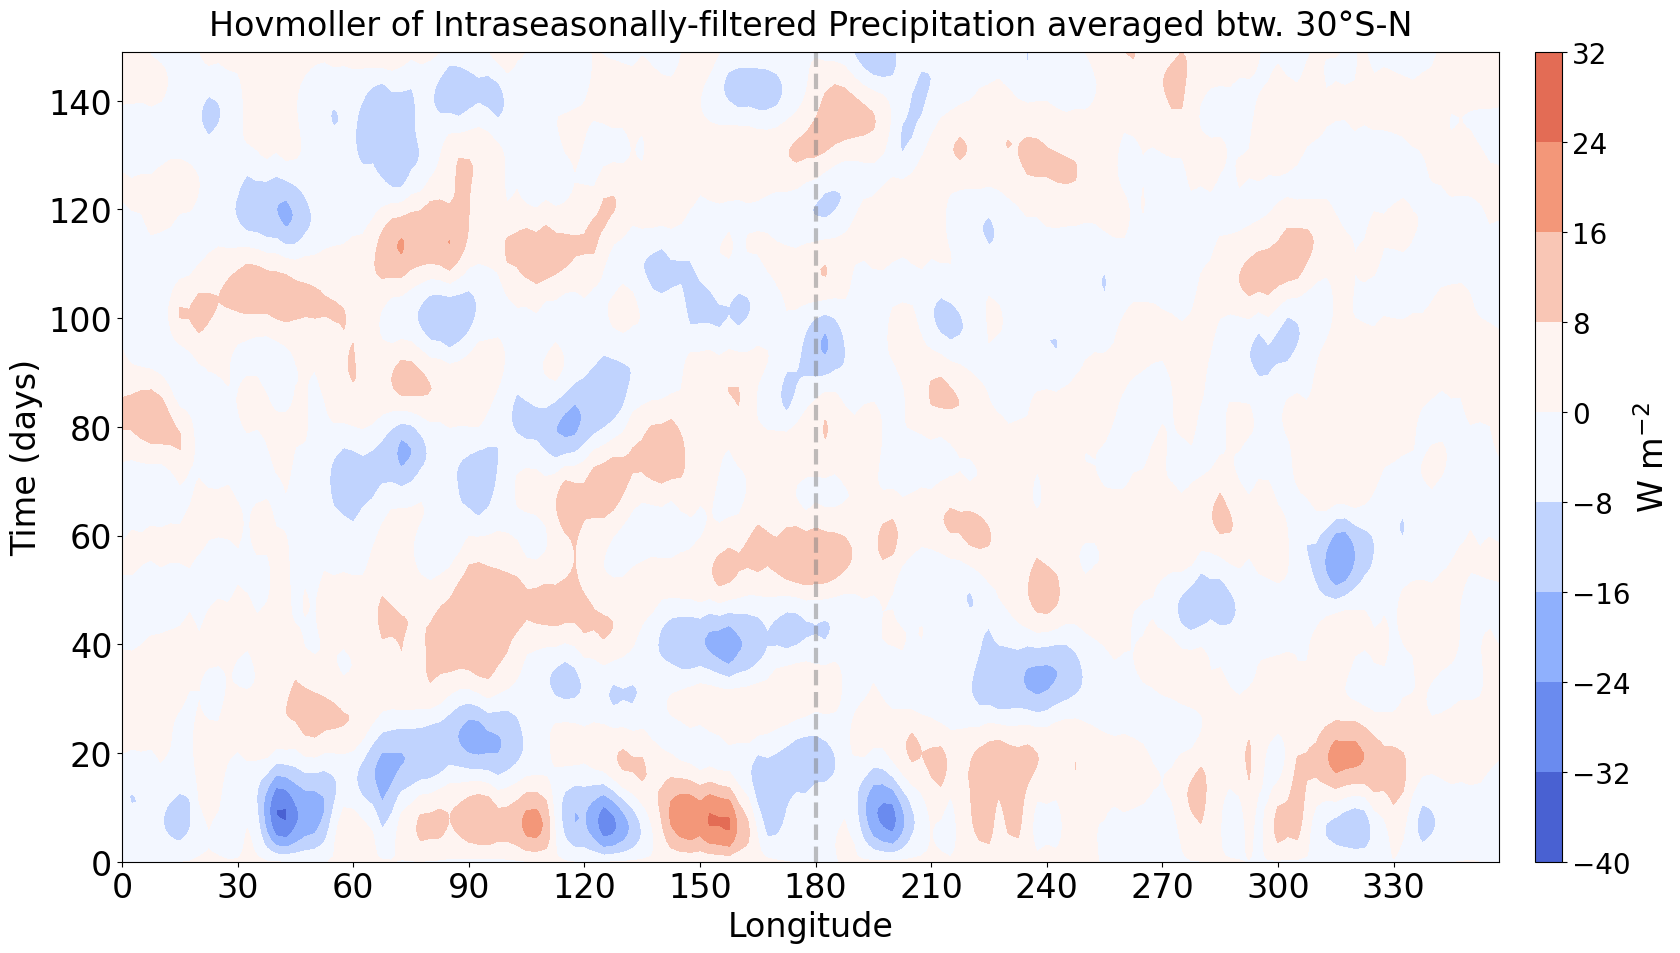

In [24]:
plt.rcParams.update({'font.size':24})

# Create figure and gridpsec
fig = plt.figure(figsize=(16,9))
gs = GridSpec(1, 2, width_ratios=[100,2])
gs.update(left=0.05, right=0.95, bottom=0.05, top=0.95, wspace=0.05)

# Specify axes
ax = fig.add_subplot(gs[0])
cbar_ax = fig.add_subplot(gs[1])

# Label plot
ax.set_title(
    f"Hovmoller of Intraseasonally-filtered Precipitation averaged btw. {LATITUDE_NORTH}°S-N", 
    fontsize=24, 
    pad=12
)

# Plot data
im = ax.contourf(
    longitude, 
    np.arange(len(time))[:150],
    variables_filtered['outgoing longwave radiation'].mean(dim='lat')[:150],
    cmap=mjo.modified_colormap('coolwarm', 'white', 0.05, 0.5),
    norm=mcolors.CenteredNorm()
)    

# Add colorbar
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.tick_params(labelsize=20)
cbar.set_label(r'W m$^{-2}$')

# Add line at 180°
ax.axvline(x=180, color='gray', lw=3, ls='--', alpha=0.5)

# Configure axes
ax.set_xticks(np.arange(0,360,30))
ax.set_aspect('auto')
ax.set_xlabel('Longitude')
ax.set_ylabel('Time (days)')

plt.show()


## Select Boreal Winter 

In [25]:
# boreal_winter_months = [11,12,1,2,3,4]

# variables_boreal_winter = {}

# for variable in variables_dict:
#     variables_boreal_winter[variable] = variables_filtered[variable].sel(time=
#         variables_filtered[variable]['time.month'].isin(boreal_winter_months)
#     )   

## Average across latitude

In [26]:
variables_meridional_average = {}

for variable in variables_dict:
    variables_meridional_average[variable] = variables_filtered[variable].copy(deep=True).mean(dim='lat')

## Standardize time series

In [27]:
variables_standardized = {}

for variable in variables_dict:
    variables_standardized[variable] = variables_meridional_average[variable].copy(deep=True)
    variables_standardized[variable].values = (
        (
            variables_meridional_average[variable] - variables_meridional_average[variable].mean()
        ) / variables_meridional_average[variable].std()
    )

## Concatenate OLR with zonal winds

In [28]:
combined_data = np.concatenate(
    [
        variables_standardized['outgoing longwave radiation'],
        variables_standardized['upper level zonal wind'],
        variables_standardized['lower level zonal wind'],
    ],
    axis=1,
)

## Compute EOFs

In [29]:
#### Calculate EOFs and PCs
U, S, VT = np.linalg.svd(combined_data.T, full_matrices=False)
EOF = U.T 
PC = np.dot(np.diag(S), VT) 

# Calculate nominal degrees of freedom
nominal_degrees_of_freedom = np.size(combined_data, 1)

# Calculate eigenvalues and spectrum
eigenvalues = S**2 / nominal_degrees_of_freedom
eigenvalue_spectrum = eigenvalues / np.sum(eigenvalues)  
explained_variance = 100*eigenvalue_spectrum

# Estimate 1-lag autocorrelation and effective degrees of freedom
lag = 1  
B = 0
for k in range(lag - 1, nominal_degrees_of_freedom - lag):
    B = B + np.sum(combined_data[:, k] * combined_data[:, k + lag])
phi_L = 1 / (nominal_degrees_of_freedom - 2 * lag) * B
phi_0 = 1 / nominal_degrees_of_freedom * np.sum(combined_data ** 2)
autocorrelation = phi_L / phi_0
degrees_of_freedom = ((1 - autocorrelation ** 2) / (1 + autocorrelation ** 2))*nominal_degrees_of_freedom

# Estimate uncertainty in eigenvalue spectrum
spectrum_error = eigenvalue_spectrum * np.sqrt(2 / degrees_of_freedom)

# Extract the EOFs of each variable from the array
olr_EOF = EOF[:, :len(longitude)]
upper_level_zonal_wind_EOF = EOF[:, len(longitude) : 2*len(longitude)]
lower_level_zonal_wind_EOF = EOF[:, 2*len(longitude):]

### Plot eigenvalue spectrum

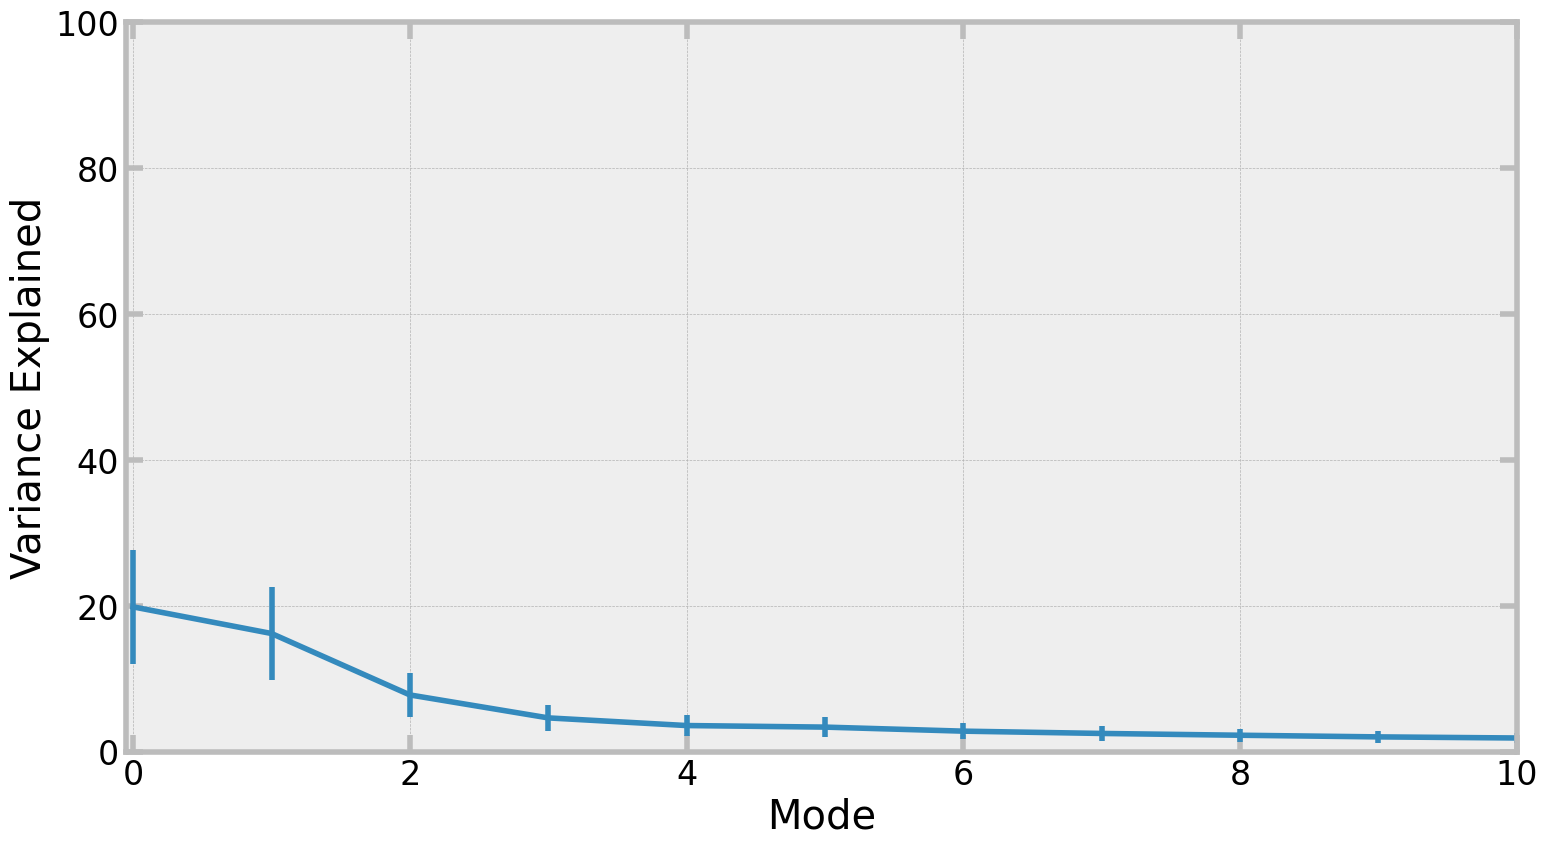

In [30]:
plt.style.use('bmh')
plt.rcParams.update({'font.size':24})

[fig, ax] = plt.subplots(figsize=(16,9))
index = np.arange(len(eigenvalues))
# ax.set_title(f'Eigenvalue Spectrum, {degrees_of_freedom:0.0f} effective degrees of freedom', pad=15)
ax.errorbar(index, 100*eigenvalue_spectrum, 100*spectrum_error, lw=4)
ax.set_ylabel('Variance Explained')
ax.set_xlabel('Mode')

# Configure and label axes
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(4)

ax.tick_params(
    axis='both', which='major', 
    length=12, width=4, 
    color='#bcbcbc', 
    direction='in',
    right=True,
    top=True,
    pad=5
)

# eof_text =  (f'EOF 1: {explained_variance[0]:0.0f}% of variance \n'
#             +f'EOF 2: {explained_variance[1]:0.0f}% of variance ')
# # Add text showing percentage of explained variance
# ax.text(9.95,0.95, eof_text, fontsize=24,
#        bbox=dict(boxstyle='round', facecolor='#eeeeee', edgecolor='#bcbcbc', alpha=0.5),
#        horizontalalignment='right', verticalalignment='top')

ax.set_ylim(0,100)
ax.set_xlim(-0.05, 10)

plt.tight_layout()
plt.show()

### Plot EOFs

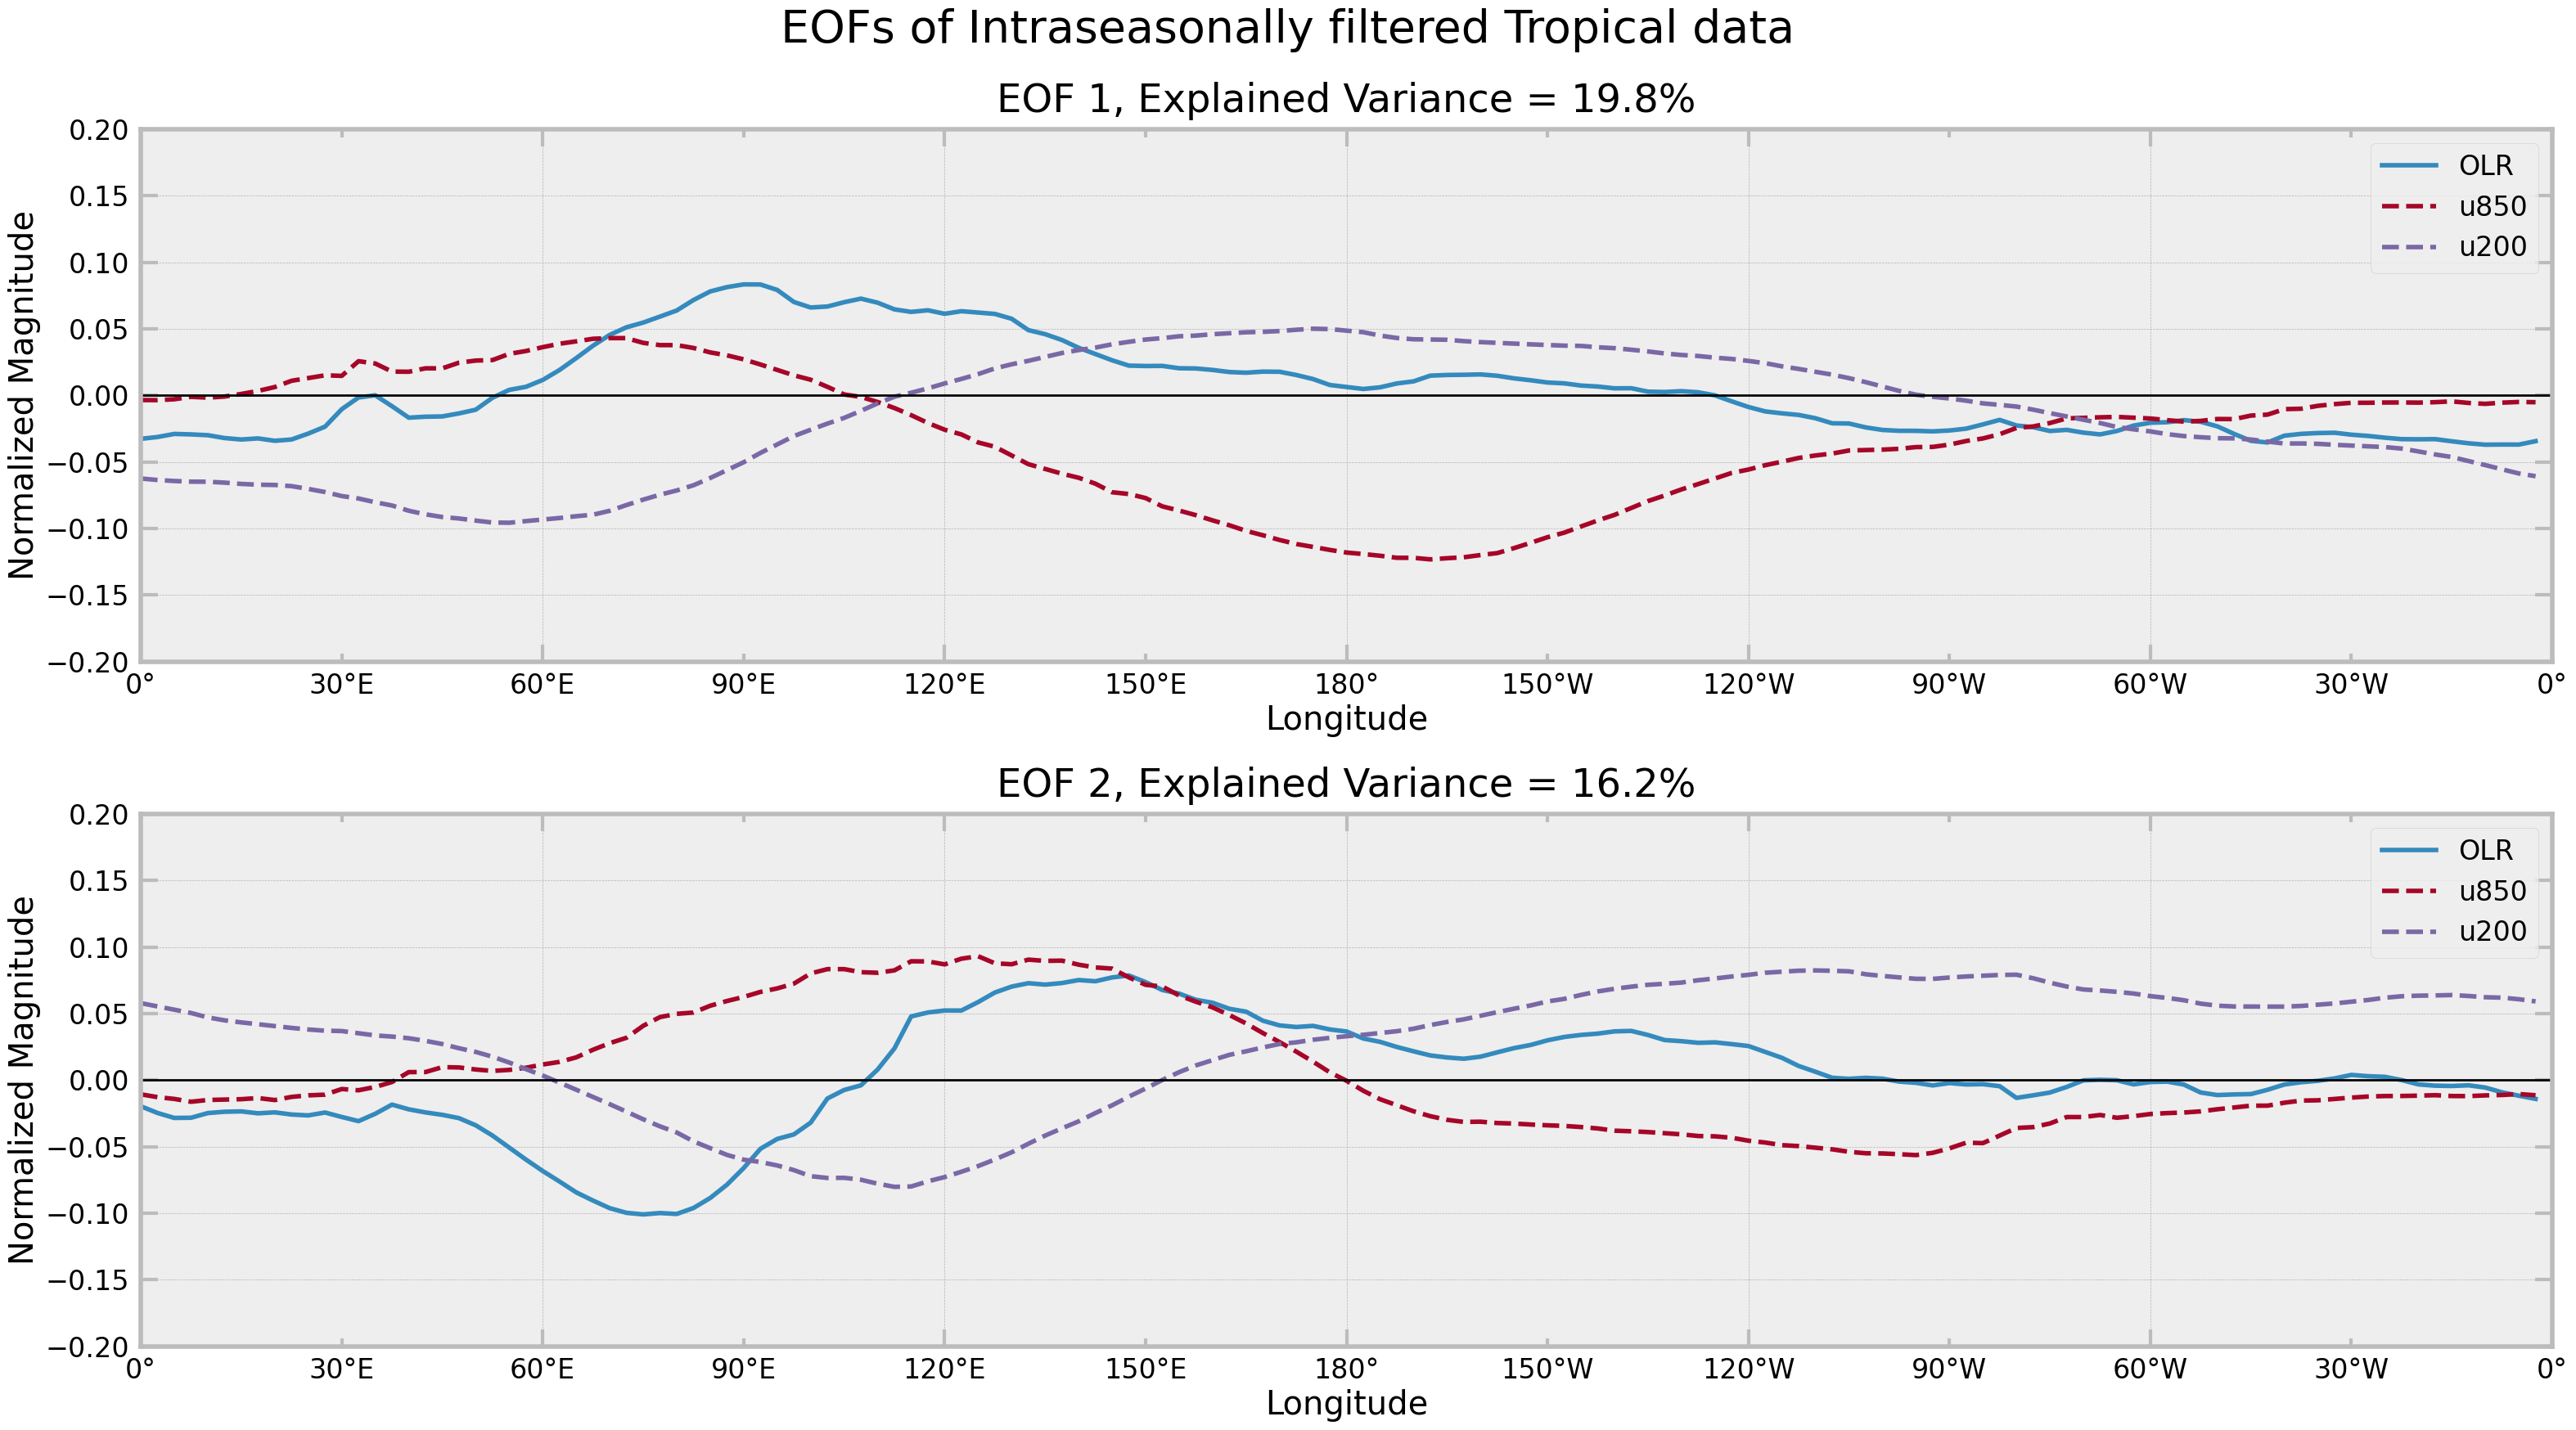

In [31]:
longitude = outgoing_longwave_radiation.lon
plt.style.use('bmh')
plt.rcParams.update({"font.size": 24})

#%% Plotting
#### EOFs as a function of latitude
[fig, ax] = plt.subplots(2, 1, figsize=(32,18))
fig.suptitle("EOFs of Intraseasonally filtered Tropical data", fontsize=40)

# EOF 1
ax[0].set_title(f"EOF 1, Explained Variance = {explained_variance[0]:0.1f}%", pad=15)
ax[0].plot(
    longitude,
    -olr_EOF[0],
    lw=4,
    label="OLR"
)
ax[0].plot(
    longitude,
    lower_level_zonal_wind_EOF[0],
    ls="--",
    lw=4,
    label="u850"
)
ax[0].plot(
    longitude,
    upper_level_zonal_wind_EOF[0],
    ls="--",
    lw=4,
    label="u200"
)
ax[0].axhline(y=0, lw=2, color="k")

# EOF 2
ax[1].set_title(f"EOF 2, Explained Variance = {explained_variance[1]:0.1f}%", pad=15)
ax[1].plot(
    longitude, 
    olr_EOF[1], 
    lw=4, 
    label="OLR"
)
ax[1].plot(
    longitude,
    -lower_level_zonal_wind_EOF[1],
    ls="--",
    lw=4,
    label="u850"
)

ax[1].plot(
    longitude,
    -upper_level_zonal_wind_EOF[1],
    ls="--",
    lw=4,
    label="u200"
)
ax[1].axhline(y=0, lw=2, color="k")

# Configure axes 
for axis in range(2):
    # Set axis labels and limits
    ax[axis].set_xlabel("Longitude")
    ax[axis].set_ylabel("Normalized Magnitude")
    ax[axis].set_xlim(0, 360)
    ax[axis].set_ylim(-0.2, 0.2)
    # ax[0].set_aspect(360 / 0.8)

    # Specify tick parameters
    ax[axis].xaxis.set_major_formatter(LongitudeFormatter())
    ax[axis].xaxis.set_major_locator(mticker.FixedLocator([0, 60, 120, 180, 240, 300, 360]))
    ax[axis].tick_params(
        which="major",
        width=3,
        length=15,
        direction="in",
        color='#bcbcbc',
        top=True,
        right=True,
        pad=10
    )
    ax[axis].xaxis.set_minor_formatter(LongitudeFormatter())
    ax[axis].xaxis.set_minor_locator(mticker.FixedLocator([30, 90, 150, 210, 270, 330]))
    ax[axis].tick_params(
        which="minor",
        width=3,
        length=7.5,
        direction="in",
        color='#bcbcbc',
        top=True,
        right=True,
        pad=10
    )

    for edge in ['top','bottom','left','right']:
        ax[axis].spines[edge].set_linewidth(4)

    ax[axis].legend(loc="upper right")

plt.tight_layout()
plt.show()

### Plot Power Spectra of PC Time Series

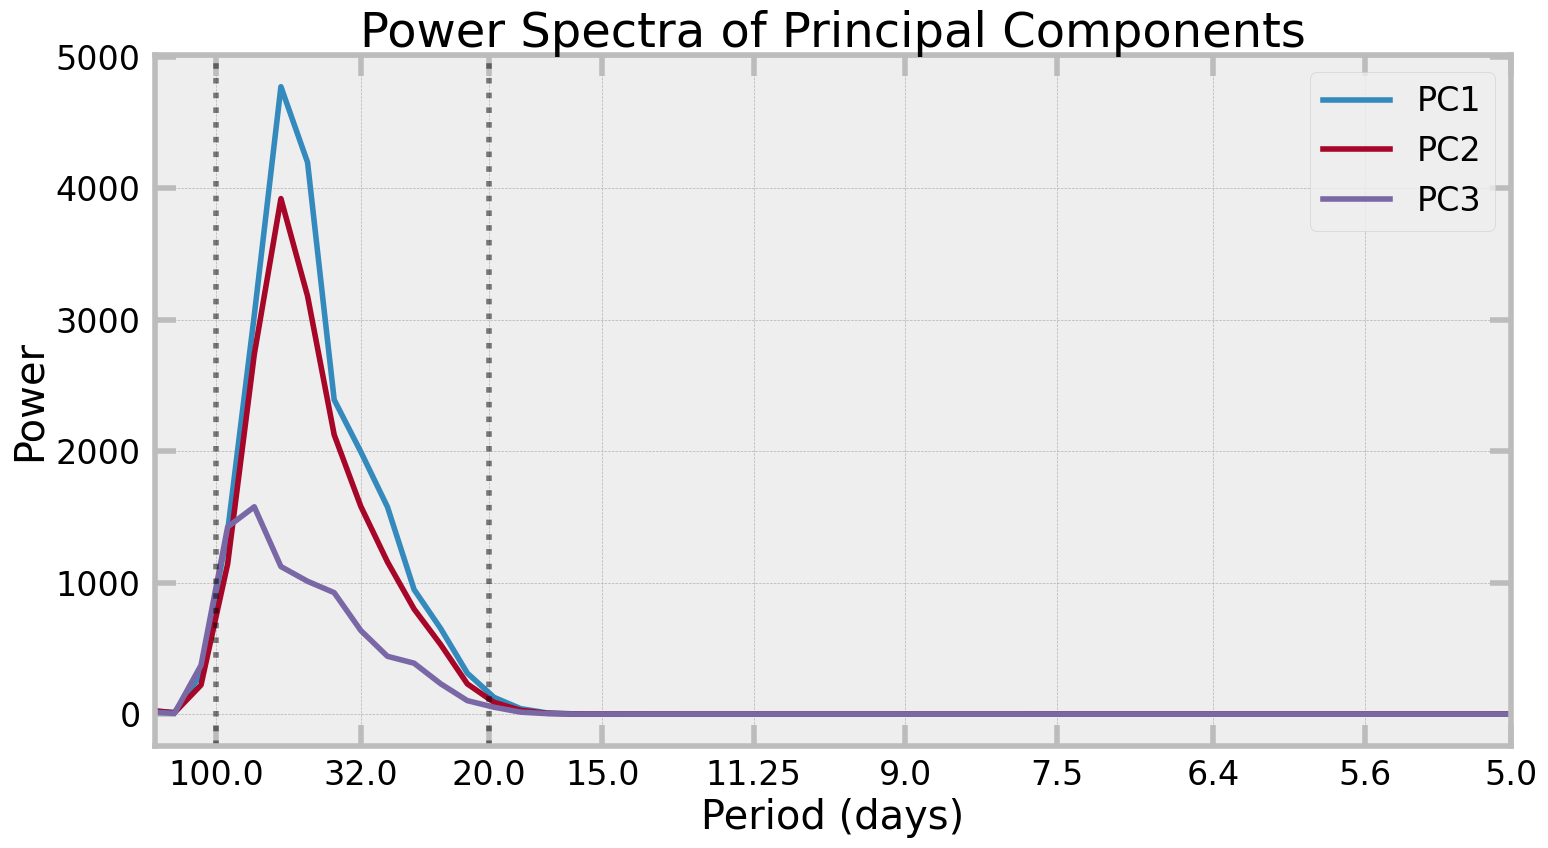

In [32]:
SEGMENT_LENGTH = 256
OVERLAP = SEGMENT_LENGTH//2
frequency = {}
spectrum = {}

for i in range(1, 4):
    (frequency[i], spectrum[i]) = signal.welch(
        PC[i - 1] - np.mean(PC[i - 1]),
        fs=1,
        window="hann",
        nperseg=SEGMENT_LENGTH,
        noverlap=OVERLAP
    )
    
# Plot the power spectra
plt.style.use('bmh')

[fig, ax] = plt.subplots(figsize=(16,9))
ax.set_title("Power Spectra of Principal Components")
for i in spectrum:
    ax.plot(
        frequency[i],
        spectrum[i],
        label=("PC" + str(i)),
        lw=4
    )

ax.tick_params(
    which='major',
    direction='in',
    color='#bcbcbc',
    length=8,
    width=2,
    pad=15
)

ax.tick_params(
    which='minor',
    direction='in',
    color='#bcbcbc',
    length=4,
    width=1,
    pad=15
)

# Add vertical lines to show the intraseasonal band
ax.axvline(x = 1/100, ls=':', lw=4, color='black', alpha=0.5)
ax.axvline(x = 1/20, ls=':', lw=4, color='black', alpha=0.5)

# Add legend
ax.legend()

# Configure axes
ax.set_ylabel('Power')
ax.set_xlabel('Period (days)')

for edge in ['top','bottom','left','right']:
    ax.spines[edge].set_linewidth(4)
ax.tick_params(
    which='major',
    axis='both',
    direction='in',
    top=True,
    right=True,
    width=4,
    length=15,
    color='#bcbcbc',
    pad=10
)    

ax.set_xticks(ticks = frequency_from_period)
ax.xaxis.set_major_formatter(mticker.FixedFormatter(periods))
ax.set_xlim(1/1000, 1/5)
    
# Set tick parameters
ax.set_xticks(ticks = frequency_from_period)
ax.xaxis.set_major_formatter(mticker.FixedFormatter(periods))
ax.set_xlim(1/1000, 1/5)
    
# Format x-axis
ax.set_xlabel("Period (days)")

ax.legend(loc="best")

plt.tight_layout()
plt.show()

## Calculate MJO Phase by RMM

In [33]:
#### Calculate phases
def compute_mjo_phase_indices(RMM1, RMM2):
    phase_times = {}
    
    # precip_times = precipitation.time.sel(
    # time=slice('1999-01-01T00:00:00.000000000', '2018-12-31T00:00:00.000000000')
    # )
    
    # Find times by phase
    phase_times[1] = time.where((RMM1 < 0) & (RMM2 < 0) & (np.abs(RMM1) > np.abs(RMM2))).dropna(dim='time')
    phase_times[2] = time.where((RMM1 < 0) & (RMM2 < 0) & (np.abs(RMM1) < np.abs(RMM2))).dropna(dim='time')
    phase_times[3] = time.where((RMM1 > 0) & (RMM2 < 0) & (np.abs(RMM1) < np.abs(RMM2))).dropna(dim='time')
    phase_times[4] = time.where((RMM1 > 0) & (RMM2 < 0) & (np.abs(RMM1) > np.abs(RMM2))).dropna(dim='time')
    phase_times[5] = time.where((RMM1 > 0) & (RMM2 > 0) & (np.abs(RMM1) > np.abs(RMM2))).dropna(dim='time')
    phase_times[6] = time.where((RMM1 > 0) & (RMM2 > 0) & (np.abs(RMM1) < np.abs(RMM2))).dropna(dim='time')
    phase_times[7] = time.where((RMM1 < 0) & (RMM2 > 0) & (np.abs(RMM1) < np.abs(RMM2))).dropna(dim='time')
    phase_times[8] = time.where((RMM1 < 0) & (RMM2 > 0) & (np.abs(RMM1) > np.abs(RMM2))).dropna(dim='time')

    # Find indices by phase
    phase_indices = {}
    
    # Find all of the points in phase 1
    phase_indices[1] = np.squeeze(
        np.where((RMM1 < 0) & (RMM2 < 0) & (np.abs(RMM1) > np.abs(RMM2)))
    )

    # Phase 2
    phase_indices[2] = np.squeeze(
        np.where((RMM1 < 0) & (RMM2 < 0) & (np.abs(RMM1) < np.abs(RMM2)))
    )

    # Phase 3
    phase_indices[3] = np.squeeze(
        np.where((RMM1 > 0) & (RMM2 < 0) & (np.abs(RMM1) < np.abs(RMM2)))
    )

    # Phase 4
    phase_indices[4] = np.squeeze(
        np.where((RMM1 > 0) & (RMM2 < 0) & (np.abs(RMM1) > np.abs(RMM2)))
    )

    # Phase 5
    phase_indices[5] = np.squeeze(
        np.where((RMM1 > 0) & (RMM2 > 0) & (np.abs(RMM1) > np.abs(RMM2)))
    )

    # Phase 6
    phase_indices[6] = np.squeeze(
        np.where((RMM1 > 0) & (RMM2 > 0) & (np.abs(RMM1) < np.abs(RMM2)))
    )

    # Phase 7
    phase_indices[7] = np.squeeze(
        np.where((RMM1 < 0) & (RMM2 > 0) & (np.abs(RMM1) < np.abs(RMM2)))
    )

    # Phase 8
    phase_indices[8] = np.squeeze(
        np.where((RMM1 < 0) & (RMM2 > 0) & (np.abs(RMM1) > np.abs(RMM2)))
    )

    return phase_indices, phase_times

### Plot RMM 

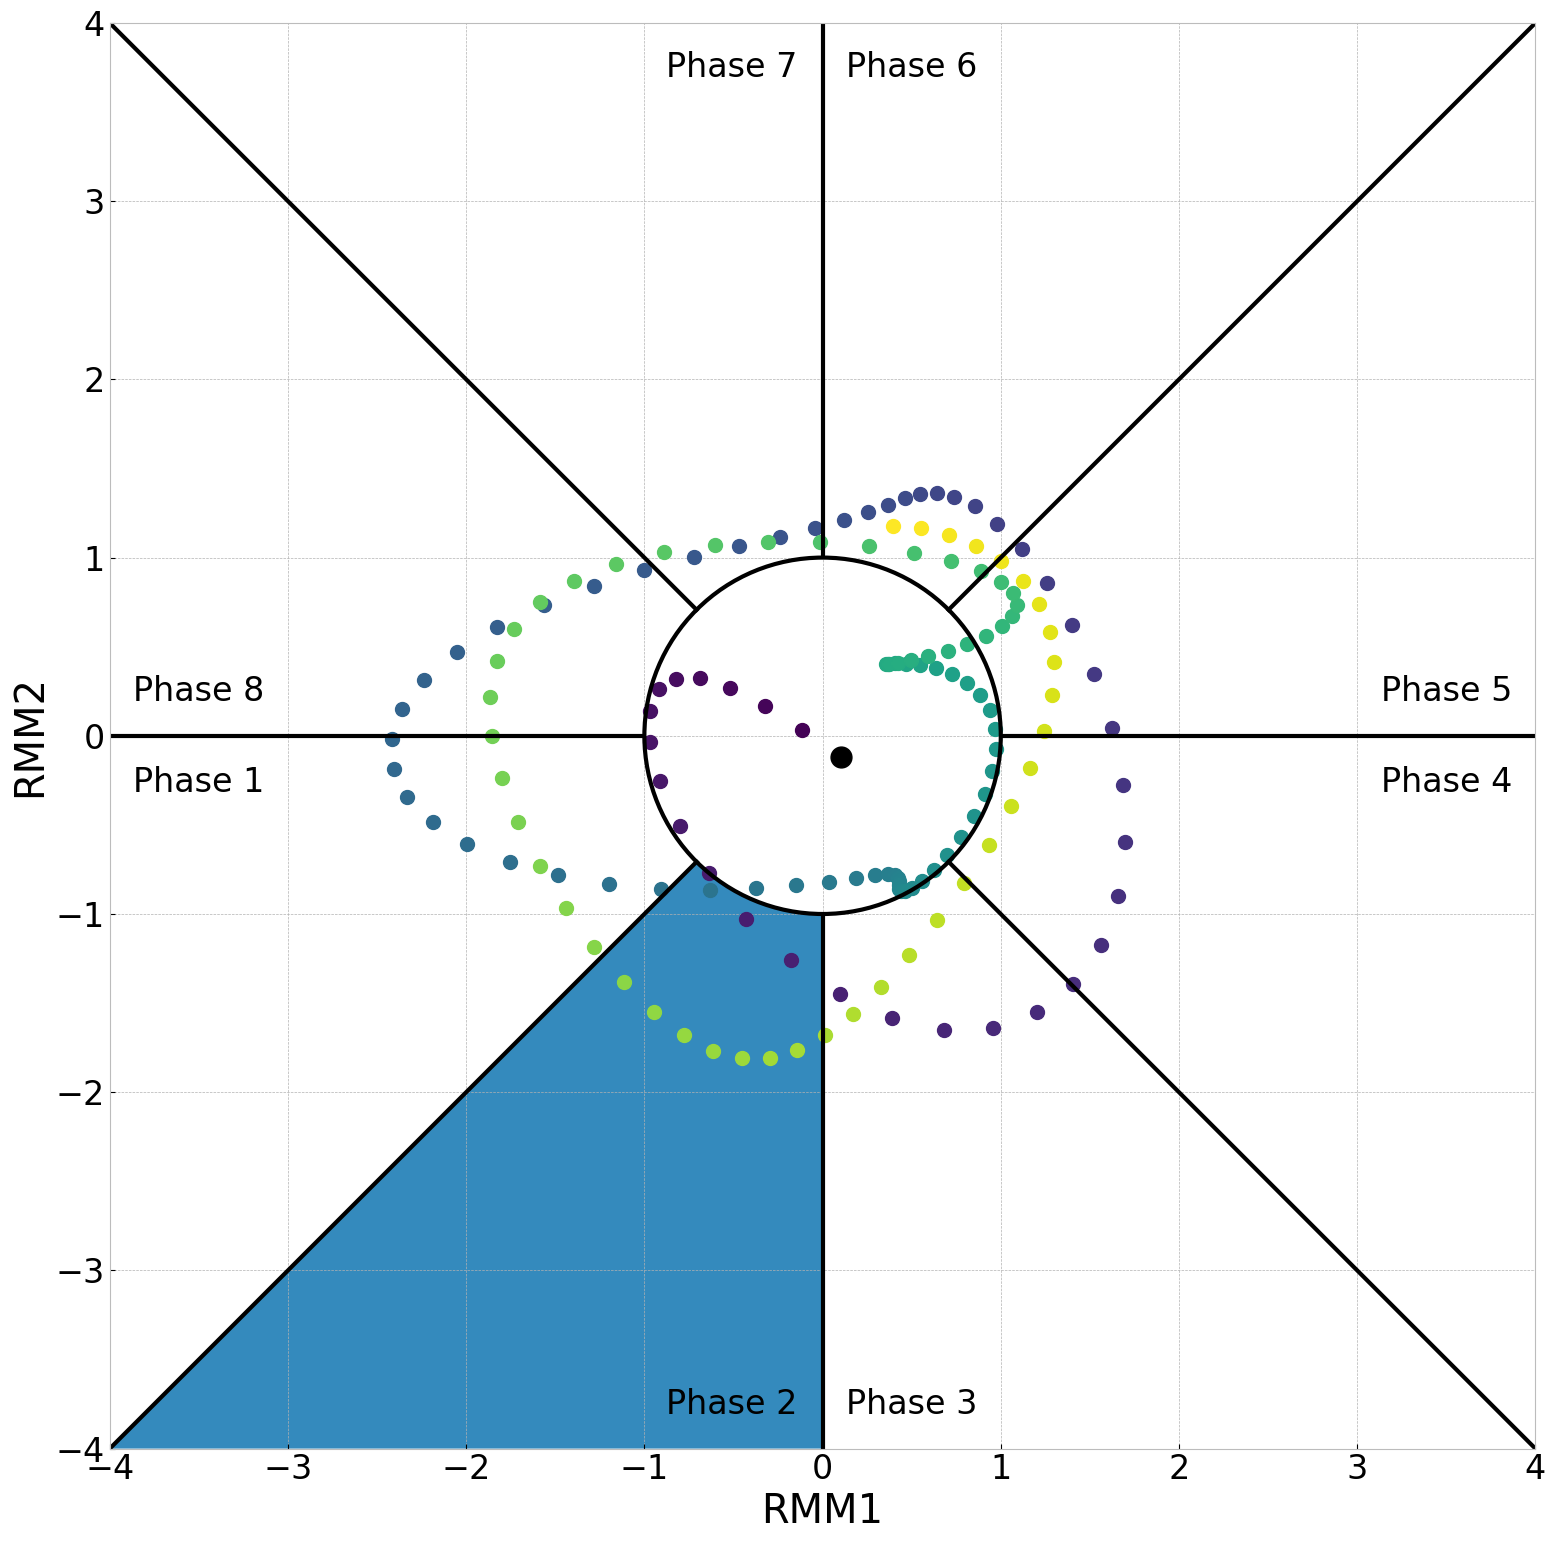

In [34]:
# Convert the principal components to an RMM-like index
RMM1 = PC[0] / np.std(PC[0])
RMM2 = -PC[1] / np.std(PC[1])
mjo_strength = np.sqrt(RMM1 ** 2 + RMM2 ** 2)

# Remove weak MJO events
# RMM1[mjo_strength < 1] = np.nan
# RMM2[mjo_strength < 1] = np.nan

RMM1 = xr.DataArray(data=RMM1, coords={'time':time})
RMM2 = xr.DataArray(data=RMM2, coords={'time':time})

[phase_indices, phase_times] = compute_mjo_phase_indices(RMM1, RMM2)

# Configure plot
[fig, ax] = plt.subplots(figsize=(16,16))
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 3
ax.set_xlim(-4, 4)
ax.set_ylim(-4, 4)
plt.xlabel("RMM1")
plt.ylabel("RMM2")
ax.set_facecolor("white")

# Plot index points
colormap = sns.color_palette("viridis", as_cmap=True)
start_index = 0
# end_index = len(RMM1) - 1
end_index = 150
ax.plot(RMM1[start_index], RMM2[start_index], color="black", marker=".", ls="-", ms=30)
for i in range(start_index + 1, end_index + 1):
    ax.plot(
        RMM1[i],
        RMM2[i],
        color=colormap((i - start_index) / (end_index - start_index)),
        marker="o",
        ms=10,
    )

# Add phase regions overlay
circle1 = plt.Circle((0, 0), 1.0, color="k", fill=False, lw=3, zorder=10)
ax.hlines(y=0, xmin=-4, xmax=-1, color="k", lw=3, ls="-")
ax.hlines(y=0, xmin=1, xmax=4, color="k", lw=3, ls="-")
ax.vlines(x=0, ymin=-4, ymax=-1, color="k", lw=3, ls="-")
ax.vlines(x=0, ymin=1, ymax=4, color="k", lw=3, ls="-")
ax.plot([np.sqrt(2) / 2, 4], [np.sqrt(2) / 2, 4], color="k", lw=3, ls="-")


x_vals = {
    1:-1,
    2:-1,
    3:1,
    4:1,
    5:1,
    6:1,
    7:-1,
    8:-1
}

y_val1 = {
    1:0,
    2:-4,
    3:-4,
    4:0,
    5:0,
    6:np.linspace(0,4,len(RMM1)),
    7:np.linspace(0,4,len(RMM1)),
    8:0
}

y_val2 = {
    1:-1*np.linspace(0, 4, len(RMM1)),
    2:-1*np.linspace(0, 4, len(RMM1)),
    3:-1*np.linspace(0, 4, len(RMM1)),
    4:-1*np.linspace(0, 4, len(RMM1)),
    5:1*np.linspace(0, 4, len(RMM1)),
    6:4,
    7:4,
    8:1*np.linspace(0, 4, len(RMM1))
}

val=2
ax.fill_between(
    x_vals[val]*np.linspace(0, 4, len(RMM1)), 
    y_val1[val], 
    y_val2[val]
)

x = np.linspace(-1,1,100)
ax.fill_between(x, -np.sqrt(1-x**2), np.sqrt(1-x**2), color='white')


ax.plot([np.sqrt(2) / 2, 4], [-np.sqrt(2) / 2, -4], color="k", lw=3, ls="-")
ax.plot([-4, -np.sqrt(2) / 2], [4, np.sqrt(2) / 2], color="k", lw=3, ls="-")
ax.plot([-4, -np.sqrt(2) / 2], [-4, -np.sqrt(2) / 2], color="k", lw=3, ls="-")
ax.add_patch(circle1)

# Add phase labels
ax.text(-3.5, -0.26, f'Phase 1',  horizontalalignment='center',
     verticalalignment='center')
ax.text(-0.51, -3.75, f'Phase 2', horizontalalignment='center',
     verticalalignment='center')
ax.text(0.5, -3.75, f'Phase 3',   horizontalalignment='center',
     verticalalignment='center')
ax.text(3.5, -0.26, f'Phase 4',   horizontalalignment='center',
     verticalalignment='center')
ax.text(3.5, 0.25, f'Phase 5',    horizontalalignment='center',
     verticalalignment='center')
ax.text(0.5, 3.75, f'Phase 6',    horizontalalignment='center',
     verticalalignment='center')
ax.text(-0.51, 3.75, f'Phase 7',  horizontalalignment='center',
     verticalalignment='center')
ax.text(-3.5, 0.25, f'Phase 8',   horizontalalignment='center',
     verticalalignment='center')

# Add MJO-location labels
# ax.text(0, 3.5, f'Western Pacific',  horizontalalignment='center',
#      verticalalignment='center', bbox=props, fontsize=14)

# ax.text(-3.3, 0, f'Western Hemisphere \n & Africa',  horizontalalignment='center',
#      verticalalignment='center', bbox=props, fontsize=14)

# ax.text(3.3, 0, f'Maritime Continent',  horizontalalignment='center',
#      verticalalignment='center', bbox=props, fontsize=14)

# ax.text(0, -3.5, f'Indian Ocean',  horizontalalignment='center',
#      verticalalignment='center', bbox=props, fontsize=14)

ax.set_aspect("equal")
plt.tight_layout()
plt.show()

In [35]:
np.sqrt(np.linspace(0, 4, len(RMM1))**2+np.linspace(0, 4, len(RMM1))**2)>1

array([False, False, False, ...,  True,  True,  True])

## Plot MJO composites

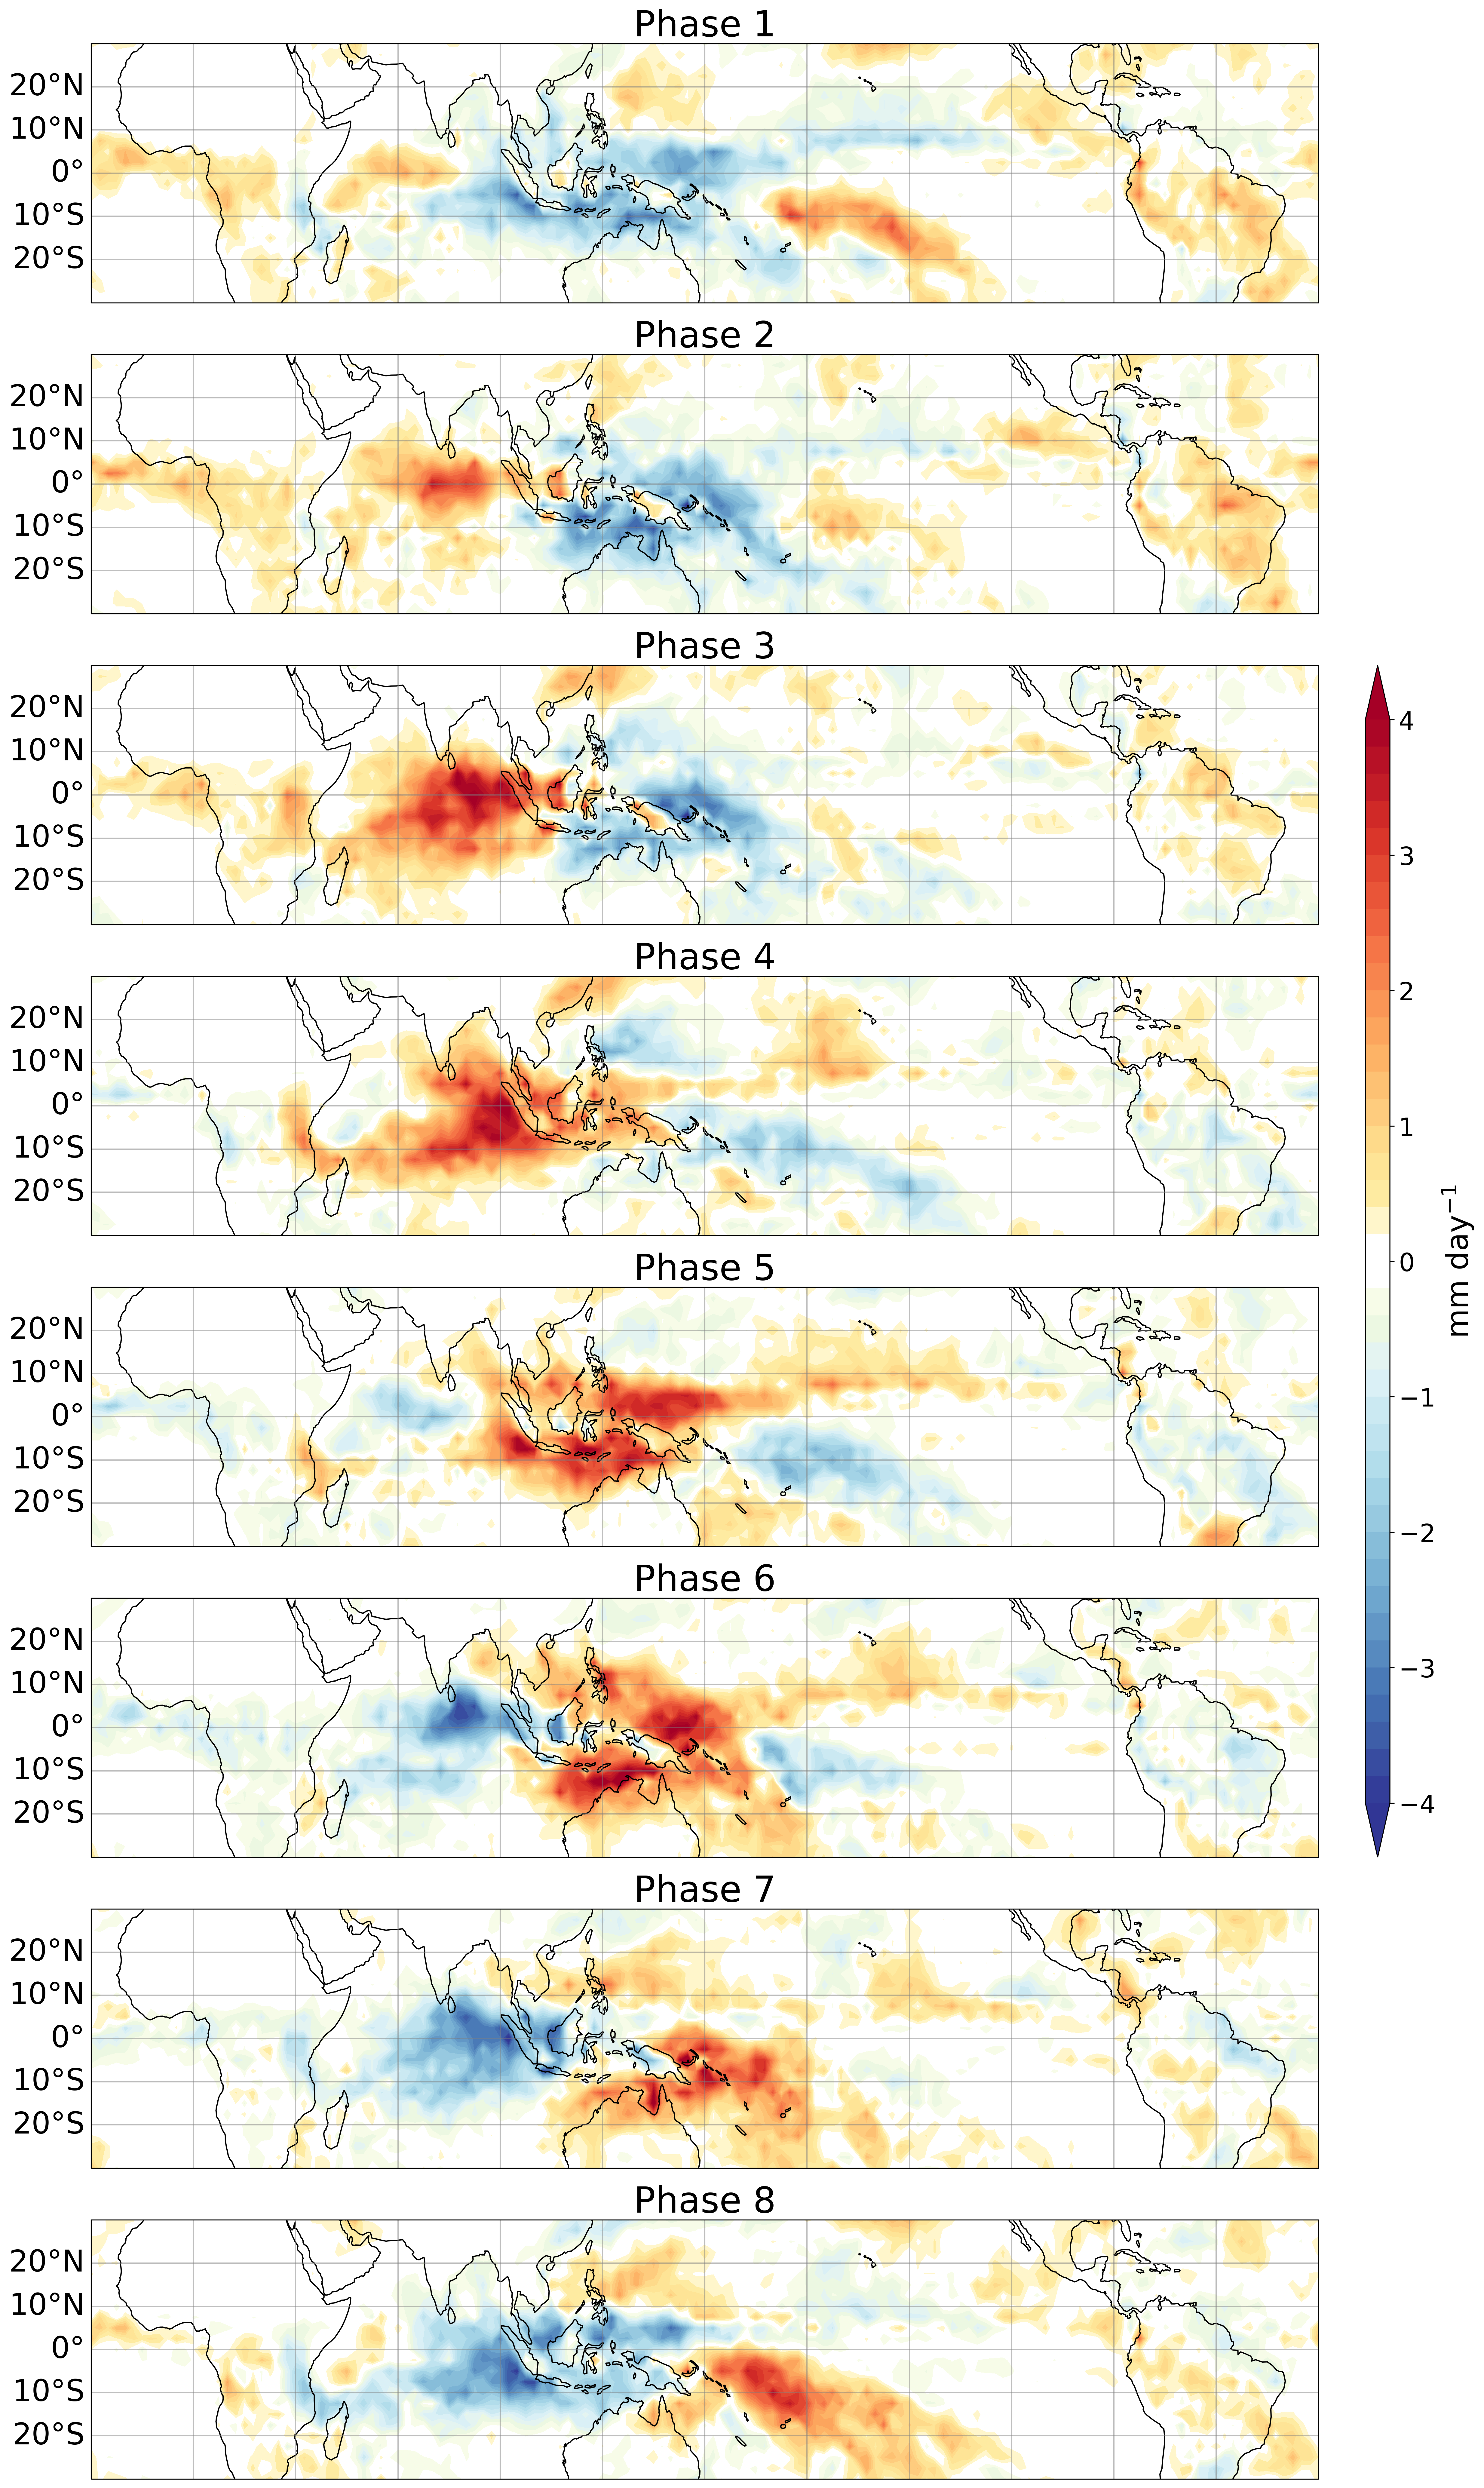

In [36]:
# Composite boreal winter rainfall anomalies by MJO phase
rainfall_anomalies_boreal_winter = variables_filtered['precipitation'].where(time['time.month'].isin([11,12,1,2,3]))

rainfall_anomalies_by_phase = {}
rainfall_filled = {}

for phase in range(1,9):
#     phase_times[phase] = phase_times[phase].sel(
#     time=slice('1999-01-01T00:00:00.000000000', '2018-12-31T00:00:00.000000000')
# )
    
    rainfall_anomalies_by_phase[phase] = rainfall_anomalies_boreal_winter.sel(time=phase_times[phase]).mean(dim='time')
    # rainfall_filled[phase] = rainfall_anomalies_by_phase[phase].where(np.abs(rainfall_anomalies_by_phase[phase]) >= 0.4)

plt.style.use('default')
plt.rcParams.update({'font.size':24})
plt.rcParams['figure.dpi']= 300
coastline_width = 1
props = dict(boxstyle='round', facecolor='#eeeeee')

data_crs = ccrs.PlateCarree()
proj = ccrs.PlateCarree(central_longitude=-205)

gs = GridSpec(8,2, width_ratios=[100,2])
gs.update(top=.95, bottom=0.05, left=0.05, right=.95, hspace=0.2, wspace=0.075)
fig = plt.figure(figsize=(16, 30))

cmap_modified = modified_colormap('RdYlBu_r', 'white', 0.05, 0.05)

keyword_args = {
    'transform':data_crs,
    'cmap':cmap_modified,
    'levels':np.linspace(-4, 4, 41),
    'norm':mcolors.CenteredNorm(vcenter=0, halfrange=4),
    'extend':'both'
}

for phase in range(1,9):
    # Add an axis object for each phase
    ax = fig.add_subplot(gs[phase-1, 0], projection=proj)
    
    ax.set_title(f"Phase {phase:0.0f}")
    
    # Add the cyclic point
    cdata, clon = cutil.add_cyclic_point(
        rainfall_anomalies_by_phase[phase],
        coord=longitude
    )
    
    # Plot rainfall by phase
    im = ax.contourf(
        clon, 
        latitude,
        cdata,
        **keyword_args
    )    

    # Map parameters
    ax.set_xlabel('')
    ax.add_feature(cf.COASTLINE, lw=coastline_width)

    gl = ax.gridlines(
        crs=proj,
        draw_labels=True,
        linewidth=1,
        color="gray",
        alpha=0.5,
        linestyle="-",

    )
    gl.right_labels = False
    gl.top_labels = False
    gl.xlocator = mticker.FixedLocator(np.arange(-180,180,30))
    # gl.xlocator = LongitudeLocator(30)
    gl.xformatter = LongitudeFormatter()
    gl.xlabel_style = {'fontsize':20}
    # gl.ylocator = mticker.FixedLocator(np.arange(-15,15,5))
    # gl.yformatter = LatitudeFormatter()
    # gl.ylabel_style = {'fontsize':20}
        
    # # Label the phase in the top left corner
    # ax.text(
    #     0.015, 
    #     0.925, 
    #     f'Phase {phase:0.0f}', 
    #     horizontalalignment='left',
    #     verticalalignment='top', 
    #     transform=ax.transAxes, 
    #     bbox=props
    # )
    
    ax.set_aspect('auto')
    
# Set colorbar
cbar_ax = fig.add_subplot(gs[2:-2,1])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.tick_params(labelsize=20)
cbar.set_label(r'mm day$^{-1}$')
    
plt.show()

### Animation


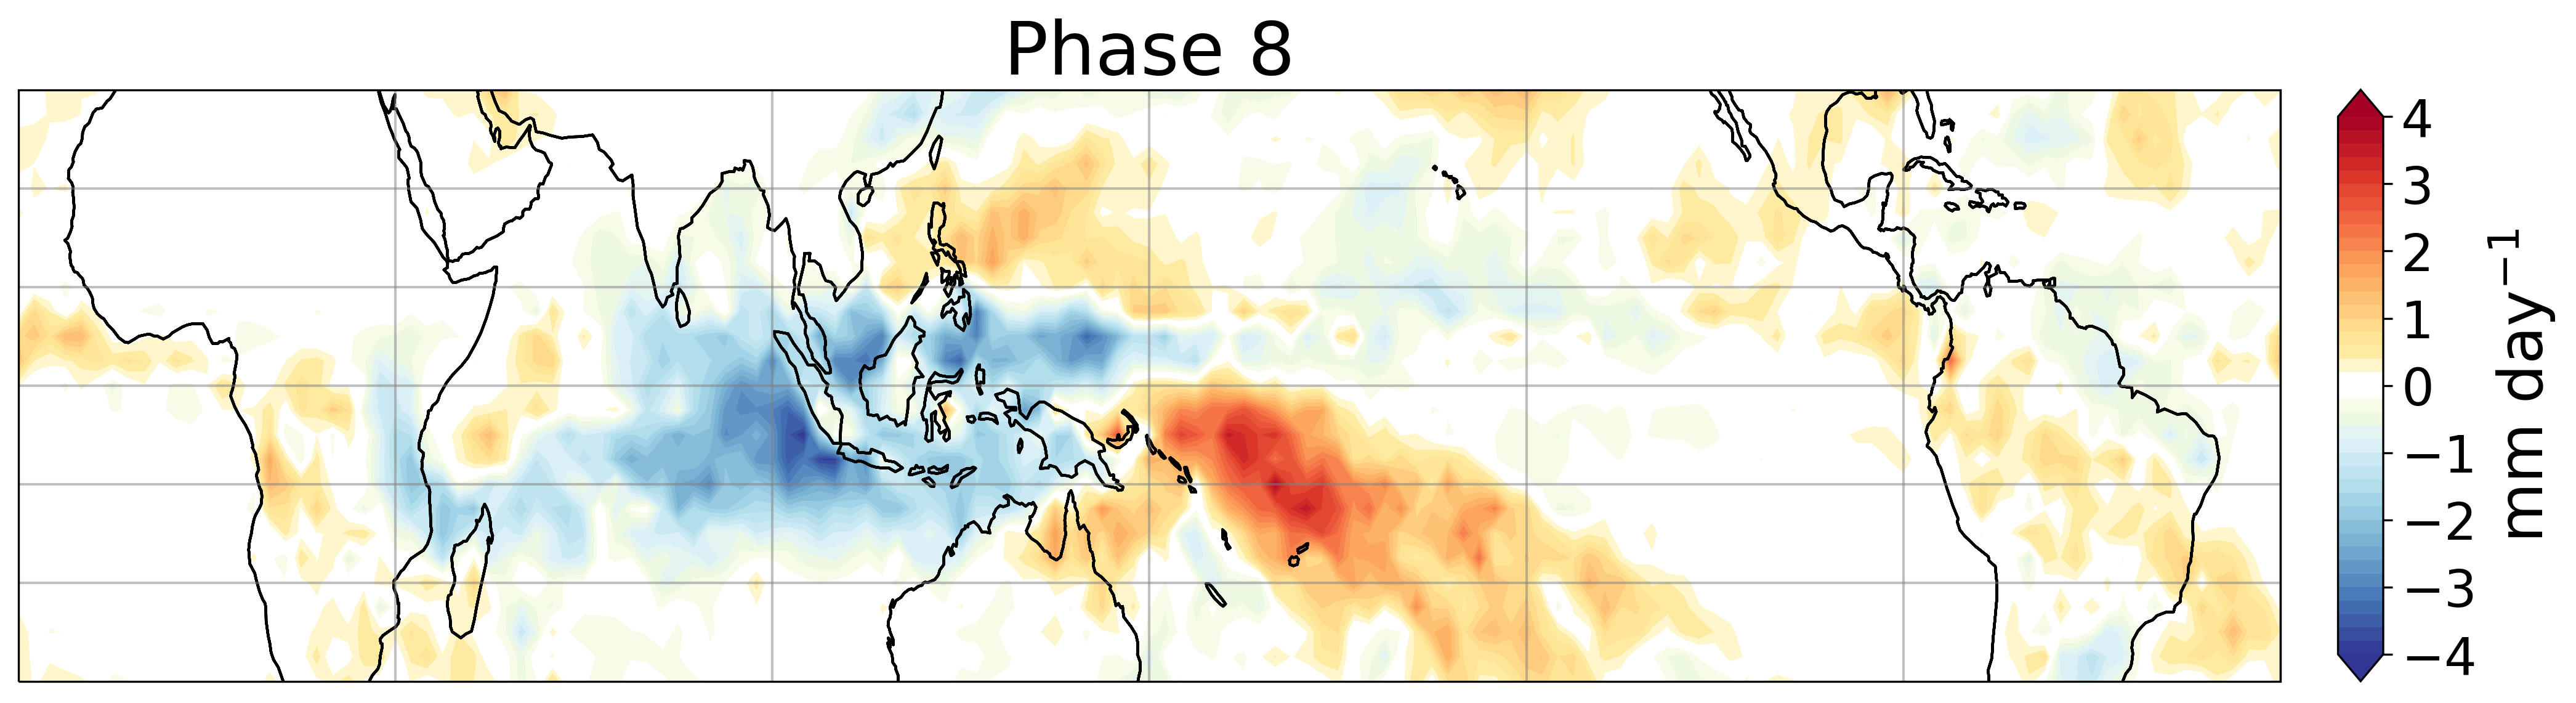

In [39]:
plt.style.use('default')
plt.rcParams.update({'font.size':24})
plt.rcParams['figure.dpi']= 300
coastline_width = 1
props = dict(boxstyle='round', facecolor='#eeeeee')

data_crs = ccrs.PlateCarree()
proj = ccrs.PlateCarree(central_longitude=-205)

gs = GridSpec(1,2, width_ratios=[100,2])
gs.update(left=0.1, right=.9, bottom=0.1, top=.9, hspace=0.15, wspace=0.05)
fig = plt.figure(figsize=(16, 4))

cmap_modified = modified_colormap('RdYlBu_r', 'white', 0.05, 0.05)

keyword_args = {
    'transform':data_crs,
    'cmap':cmap_modified,
    'levels':np.linspace(-4, 4, 41),
    'norm':mcolors.CenteredNorm(vcenter=0, halfrange=4),
    'extend':'both'
}

# Add an axis object for each phase
ax = fig.add_subplot(gs[0], projection=proj)
cbar_ax = fig.add_subplot(gs[1])

# # inset_ax = plt.axes([0.03, 0.7, 0.3, 0.3])
# inset_x = 0.2
# inset_y = 0.01
# inset_width = 0.3
# inset_height = 0.3

# # Add the inset to the figure
# inset_ax = ax.inset_axes([inset_x, 1-inset_y-inset_height, inset_width, inset_height])
# inset_ax.set_aspect('equal')

# # Add phase regions overlay
# circle1 = plt.Circle((0, 0), 1.0, color="k", fill=False, lw=1, zorder=10)
# inset_ax.hlines(y=0, xmin=-4, xmax=-1, color="k", lw=1, ls="-")
# inset_ax.hlines(y=0, xmin=1, xmax=4, color="k", lw=1, ls="-")
# inset_ax.vlines(x=0, ymin=-4, ymax=-1, color="k", lw=1, ls="-")
# inset_ax.vlines(x=0, ymin=1, ymax=4, color="k", lw=1, ls="-")
# inset_ax.plot([np.sqrt(2) / 2, 4], [np.sqrt(2) / 2, 4], color="k", lw=1, ls="-")
# inset_ax.set_xticks([])
# inset_ax.set_yticks([])

# x_vals = {
#     1:-1,
#     2:-1,
#     3:1,
#     4:1,
#     5:1,
#     6:1,
#     7:-1,
#     8:-1
# }

# y_val1 = {
#     1:0,
#     2:-4,
#     3:-4,
#     4:0,
#     5:0,
#     6:np.linspace(0,4,len(RMM1)),
#     7:np.linspace(0,4,len(RMM1)),
#     8:0
# }

# y_val2 = {
#     1:-1*np.linspace(0, 4, len(RMM1)),
#     2:-1*np.linspace(0, 4, len(RMM1)),
#     3:-1*np.linspace(0, 4, len(RMM1)),
#     4:-1*np.linspace(0, 4, len(RMM1)),
#     5:1*np.linspace(0, 4, len(RMM1)),
#     6:4,
#     7:4,
#     8:1*np.linspace(0, 4, len(RMM1))
# }

# val=1
# x = np.linspace(-1,1,100)
# fill = inset_ax.fill_between(
#     x_vals[val]*np.linspace(0, 4, len(RMM1)), 
#     y_val1[val], 
#     y_val2[val]
# )
# fill2 = inset_ax.fill_between(x, -np.sqrt(1-x**2), np.sqrt(1-x**2), color='white')


# inset_ax.plot([np.sqrt(2) / 2, 4], [-np.sqrt(2) / 2, -4], color="k", lw=1, ls="-")
# inset_ax.plot([-4, -np.sqrt(2) / 2], [4, np.sqrt(2) / 2], color="k", lw=1, ls="-")
# inset_ax.plot([-4, -np.sqrt(2) / 2], [-4, -np.sqrt(2) / 2], color="k", lw=1, ls="-")
# inset_ax.add_patch(circle1)

# # # Add phase labels
# inset_ax.text(-3.5, -0.26, f'1',  horizontalalignment='center',
#      verticalalignment='center', fontsize=6)
# inset_ax.text(-0.51, -3.75, f'2', horizontalalignment='center',
#      verticalalignment='center', fontsize=6)
# inset_ax.text(0.5, -3.75, f'3',   horizontalalignment='center',
#      verticalalignment='center', fontsize=6)
# inset_ax.text(3.5, -0.26, f'4',   horizontalalignment='center',
#      verticalalignment='center', fontsize=6)
# inset_ax.text(3.5, 0.25, f'5',    horizontalalignment='center',
#      verticalalignment='center', fontsize=6)
# inset_ax.text(0.5, 3.75, f'6',    horizontalalignment='center',
#      verticalalignment='center', fontsize=6)
# inset_ax.text(-0.51, 3.75, f'7',  horizontalalignment='center',
#      verticalalignment='center', fontsize=6)
# inset_ax.text(-3.5, 0.25, f'8',   horizontalalignment='center',
#      verticalalignment='center', fontsize=6)


ax.set_title(f"Phase {1:0.0f}")

# Add the cyclic point
cdata, clon = cutil.add_cyclic_point(
    rainfall_anomalies_by_phase[phase],
    coord=longitude
)

# Plot rainfall by phase
im = ax.contourf(
    clon, 
    latitude,
    cdata,
    **keyword_args
)    

# Set colorbar
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.tick_params(labelsize=20)
cbar.set_label(r'mm day$^{-1}$')

# Map parameters
ax.set_xlabel('')
ax.add_feature(cf.COASTLINE, lw=coastline_width)

gl = ax.gridlines(
    crs=proj,
    draw_labels=False,
    linewidth=1,
    color="gray",
    alpha=0.5,
    linestyle=":"
)
# gl.right_labels = False
# gl.top_labels = False
# gl.xlocator = mticker.FixedLocator(np.arange(-180,180,30))
# # gl.xlocator = LongitudeLocator(30)
# gl.xformatter = LongitudeFormatter()
# gl.xlabel_style = {'fontsize':20}
# # gl.ylocator = mticker.FixedLocator(np.arange(-15,15,5))
# # gl.yformatter = LatitudeFormatter()
# # gl.ylabel_style = {'fontsize':20}

# # Label the phase in the top left corner
# text= ax.text(
#     0.015, 
#     0.925, 
#     f'Phase {1:0.0f}', 
#     horizontalalignment='left',
#     verticalalignment='top', 
#     transform=ax.transAxes, 
#     bbox=props
# )

ax.set_aspect('auto')

def update(frame):
    ax.set_title(f"Phase {frame+1:0.0f}")

    # Add the cyclic point
    cdata, clon = cutil.add_cyclic_point(
        rainfall_anomalies_by_phase[frame+1],
        coord=longitude
    )

    # Plot rainfall by phase
    im = ax.contourf(
        clon, 
        latitude,
        cdata,
        **keyword_args
    )    
        
#     text = ax.text(
#         0.015, 
#         0.925, 
#         f'Phase {frame+1:0.0f}', 
#         horizontalalignment='left',
#         verticalalignment='top', 
#         transform=ax.transAxes, 
#         bbox=props
# )
        
    # Map parameters
    ax.set_xlabel('')
    ax.add_feature(cf.COASTLINE, lw=coastline_width)

#     fill = inset_ax.fill_between(
#         x_vals[frame+1]*np.linspace(0, 4, len(RMM1)), 
#         y_val1[frame+1], 
#         y_val2[frame+1],
#         color='#1f77b4'
#     )
    
#     if frame != 0:
#         fill = inset_ax.fill_between(
#         x_vals[frame]*np.linspace(0, 4, len(RMM1)), 
#         y_val1[frame], 
#         y_val2[frame],
#         color='white'
#         )
#     fill2 = inset_ax.fill_between(x, -np.sqrt(1-x**2), np.sqrt(1-x**2), color='white')
    
    return im, #fill, fill2

# Create the animation
animation = FuncAnimation(fig, update, frames=8, interval=400)

animation.save('mjo_phases.gif', dpi=300)